In [1]:
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline
import sklearn
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.manifold import TSNE
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix,roc_curve, roc_auc_score
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator
import json

In [115]:
!pip install --pre pycaret

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.9/485.9 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 21.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.5/160.5 kB 12.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.0/258.0 kB 23.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 11.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 26.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 12.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.8/106.8 kB 14.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.7/80.7 kB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.9/21.9 MB 69.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 40.

In [2]:
print("Num GPUs Available:", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available: 1


In [3]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:

i = 0
with h5py.File("/content/drive/MyDrive/per-protein.h5", "r") as file:
    print(f"number of entries: {len(file.items())}")
    for sequence_id, embedding in file.items():
        i += 1
        print(
            f"  id: {sequence_id}, "
            f"  embeddings shape: {embedding.shape}, "
            f"  embeddings mean: {np.array(embedding).mean()}"
        )
        if i == 10:
          break

number of entries: 571272
  id: A0A009IHW8,   embeddings shape: (1024,),   embeddings mean: -0.0008711814880371094
  id: A0A011QK89,   embeddings shape: (1024,),   embeddings mean: -0.00095367431640625
  id: A0A017SE81,   embeddings shape: (1024,),   embeddings mean: -0.0003161430358886719
  id: A0A017SE85,   embeddings shape: (1024,),   embeddings mean: -0.0011615753173828125
  id: A0A017SEF3,   embeddings shape: (1024,),   embeddings mean: 0.0008940696716308594
  id: A0A017SEX7,   embeddings shape: (1024,),   embeddings mean: -0.00021350383758544922
  id: A0A017SEY2,   embeddings shape: (1024,),   embeddings mean: -0.0007681846618652344
  id: A0A017SFB8,   embeddings shape: (1024,),   embeddings mean: -0.0002608299255371094
  id: A0A017SGC7,   embeddings shape: (1024,),   embeddings mean: -0.00025343894958496094
  id: A0A017SP50,   embeddings shape: (1024,),   embeddings mean: 0.0007491111755371094


In [5]:
json_path = "/content/drive/MyDrive/protein_props.json"
with open(json_path) as f:
  data = json.load(f)
len(data)

20434

In [6]:
okk = pd.read_json(json_path)
properties = okk.transpose()

In [7]:
druggable_data = "/content/drive/MyDrive/druggable_proteins.txt"
with open(druggable_data) as f:
  druggable_proteins = [line.strip() for line in f]
print(len(druggable_proteins))

approved_drugs = "/content/drive/MyDrive/approved_druggable_proteins.txt"
with open(approved_drugs) as g:
  approved_proteins = [line.strip() for line in g]
print(len(approved_proteins))

3345
2652


In [8]:
properties

Sequence Sequence Length  \
A0A087X1C5  MGLEALVPLAMIVAIFLLLVDLMHRHQRWAARYPPGPLPLPGLGNL...             515   
A0A0B4J2F0  MFRRLTFAQLLFATVLGIAGGVYIFQPVFEQYAKDQKELKEKMQLV...              54   
A0A0B4J2F2  MVIMSEFSADPAGQGQGQQKPLRVGFYDIERTLGKGNFAVVKLARH...             783   
A0A0C5B5G6                                   MRWQEMGYIFYPRKLR              16   
A0A0K2S4Q6  MTQRAGAAMLPSALLLLCVPGCLTVSGPSTVMGAVGESLSVQCRYE...             201   
...                                                       ...             ...   
Q9UI54      MESPKCLYSRITVNTAFGTKFSHISFIILFKVFLFPRITISKKTKL...              55   
Q9UI72      MGMALELYWLCGFRSYWPLGTNAENEGNRKENRRQMQSRNERGCNV...              69   
Q9Y3F1      MSLLWTPQILTISFVSYILSLFPSPFPSCYTSCWFETSITTEKELN...              56   
Q9Y6C7      MAHHSLNTFYIWHNNVLHTHLVFFLPHLLNQPFSRGSFLIWLLLCW...              94   
Q9Y6Z2      MGTAVGPHHSPAPHDSALPARLLTSDFPYGRSCQIEQVKYSVPDTG...              57   

           Molecular Weight     GRAVY  \
A0A087X1C5       57488.0269 -0.016117   
A0A0B4J2F0        6313.3024 -0.235185   
A0A0B4J2F2       84929.1856 -0.197957   
A0A0C5B5G6        2174.5917   -0.9375   
A0A0K2S4Q6       21805.9293   0.10796   
...                     ...       ...   
Q9UI54             6386.613  0.303636   
Q9UI72            8249.2539 -1.015942   
Q9Y3F1            6534.5215  0.444643   
Q9Y6C7           11023.7471 -0.029787   
Q9Y6Z2            6188.8293 -0.421053   

                                             Amino Acid Count  \
A0A087X1C5  {'A': 42, 'C': 9, 'D': 23, 'E': 28, 'F': 31, '...   
A0A0B4J2F0  {'A': 4, 'C': 0, 'D': 1, 'E': 6, 'F': 5, 'G': ...   
A0A0B4J2F2  {'A': 66, 'C': 19, 'D': 30, 'E': 43, 'F': 28, ...   
A0A0C5B5G6  {'A': 0, 'C': 0, 'D': 0, 'E': 1, 'F': 1, 'G': ...   
A0A0K2S4Q6  {'A': 11, 'C': 8, 'D': 7, 'E': 10, 'F': 6, 'G'...   
...                                                       ...   
Q9UI54      {'A': 1, 'C': 1, 'D': 0, 'E': 1, 'F': 6, 'G': ...   
Q9UI72      {'A': 4, 'C': 3, 'D': 2, 'E': 6, 'F': 2, 'G': ...   
Q9Y3F1      {'A': 2, 'C': 2, 'D': 0, 'E': 4, 'F': 6, 'G': ...   
Q9Y6C7      {'A': 4, 'C': 2, 'D': 1, 'E': 1, 'F': 5, 'G': ...   
Q9Y6Z2      {'A': 4, 'C': 1, 'D': 3, 'E': 2, 'F': 2, 'G': ...   

                                           Amino Acid Percent  \
A0A087X1C5  {'A': 0.081553398058252, 'C': 0.01747572815533...   
A0A0B4J2F0  {'A': 0.074074074074074, 'C': 0.0, 'D': 0.0185...   
A0A0B4J2F2  {'A': 0.08429118773946301, 'C': 0.024265644955...   
A0A0C5B5G6  {'A': 0.0, 'C': 0.0, 'D': 0.0, 'E': 0.0625, 'F...   
A0A0K2S4Q6  {'A': 0.054726368159203, 'C': 0.03980099502487...   
...                                                       ...   
Q9UI54      {'A': 0.018181818181818, 'C': 0.01818181818181...   
Q9UI72      {'A': 0.057971014492753006, 'C': 0.04347826086...   
Q9Y3F1      {'A': 0.035714285714285005, 'C': 0.03571428571...   
Q9Y6C7      {'A': 0.042553191489361, 'C': 0.02127659574468...   
Q9Y6Z2      {'A': 0.070175438596491, 'C': 0.01754385964912...   

           Molar Extinction Coefficient Isoelectric Point Instability Index  \
A0A087X1C5               [47440, 47940]          8.703506         45.155922   
A0A0B4J2F0                 [2980, 2980]           8.03542         55.518519   
A0A0B4J2F2               [56840, 57965]          6.813029         59.277803   
A0A0C5B5G6                 [8480, 8480]         10.266413         77.300625   
A0A0K2S4Q6               [33460, 33960]          5.366988         41.796517   
...                                 ...               ...               ...   
Q9UI54                     [2980, 2980]         10.302902         35.789091   
Q9UI72                   [15470, 15595]          9.348383         46.171014   
Q9Y3F1                   [15470, 15595]          4.493088            69.675   
Q9Y6C7                   [24980, 25105]         10.192468         62.375638   
Q9Y6Z2                     [8480, 8480]          5.982781              50.3   

           Aromaticity                                Secondary Structure  \

In [9]:
embeddings = []
embedding_means = []

with h5py.File("/content/drive/MyDrive/per-protein.h5", "r") as file:
    for protein_id in properties.index:
        if protein_id in file:
            embedding = file[protein_id][()]
            embedding_mean = embedding.mean()
        else:
            embedding = np.nan
            embedding_mean = np.nan
        embeddings.append(embedding)
        embedding_means.append(embedding_mean)

# Add the embeddings and embedding means as new columns to the DataFrame
properties['embeddings'] = embeddings
properties['embedding_mean'] = embedding_means

In [10]:
properties

Sequence Sequence Length  \
A0A087X1C5  MGLEALVPLAMIVAIFLLLVDLMHRHQRWAARYPPGPLPLPGLGNL...             515   
A0A0B4J2F0  MFRRLTFAQLLFATVLGIAGGVYIFQPVFEQYAKDQKELKEKMQLV...              54   
A0A0B4J2F2  MVIMSEFSADPAGQGQGQQKPLRVGFYDIERTLGKGNFAVVKLARH...             783   
A0A0C5B5G6                                   MRWQEMGYIFYPRKLR              16   
A0A0K2S4Q6  MTQRAGAAMLPSALLLLCVPGCLTVSGPSTVMGAVGESLSVQCRYE...             201   
...                                                       ...             ...   
Q9UI54      MESPKCLYSRITVNTAFGTKFSHISFIILFKVFLFPRITISKKTKL...              55   
Q9UI72      MGMALELYWLCGFRSYWPLGTNAENEGNRKENRRQMQSRNERGCNV...              69   
Q9Y3F1      MSLLWTPQILTISFVSYILSLFPSPFPSCYTSCWFETSITTEKELN...              56   
Q9Y6C7      MAHHSLNTFYIWHNNVLHTHLVFFLPHLLNQPFSRGSFLIWLLLCW...              94   
Q9Y6Z2      MGTAVGPHHSPAPHDSALPARLLTSDFPYGRSCQIEQVKYSVPDTG...              57   

           Molecular Weight     GRAVY  \
A0A087X1C5       57488.0269 -0.016117   
A0A0B4J2F0        6313.3024 -0.235185   
A0A0B4J2F2       84929.1856 -0.197957   
A0A0C5B5G6        2174.5917   -0.9375   
A0A0K2S4Q6       21805.9293   0.10796   
...                     ...       ...   
Q9UI54             6386.613  0.303636   
Q9UI72            8249.2539 -1.015942   
Q9Y3F1            6534.5215  0.444643   
Q9Y6C7           11023.7471 -0.029787   
Q9Y6Z2            6188.8293 -0.421053   

                                             Amino Acid Count  \
A0A087X1C5  {'A': 42, 'C': 9, 'D': 23, 'E': 28, 'F': 31, '...   
A0A0B4J2F0  {'A': 4, 'C': 0, 'D': 1, 'E': 6, 'F': 5, 'G': ...   
A0A0B4J2F2  {'A': 66, 'C': 19, 'D': 30, 'E': 43, 'F': 28, ...   
A0A0C5B5G6  {'A': 0, 'C': 0, 'D': 0, 'E': 1, 'F': 1, 'G': ...   
A0A0K2S4Q6  {'A': 11, 'C': 8, 'D': 7, 'E': 10, 'F': 6, 'G'...   
...                                                       ...   
Q9UI54      {'A': 1, 'C': 1, 'D': 0, 'E': 1, 'F': 6, 'G': ...   
Q9UI72      {'A': 4, 'C': 3, 'D': 2, 'E': 6, 'F': 2, 'G': ...   
Q9Y3F1      {'A': 2, 'C': 2, 'D': 0, 'E': 4, 'F': 6, 'G': ...   
Q9Y6C7      {'A': 4, 'C': 2, 'D': 1, 'E': 1, 'F': 5, 'G': ...   
Q9Y6Z2      {'A': 4, 'C': 1, 'D': 3, 'E': 2, 'F': 2, 'G': ...   

                                           Amino Acid Percent  \
A0A087X1C5  {'A': 0.081553398058252, 'C': 0.01747572815533...   
A0A0B4J2F0  {'A': 0.074074074074074, 'C': 0.0, 'D': 0.0185...   
A0A0B4J2F2  {'A': 0.08429118773946301, 'C': 0.024265644955...   
A0A0C5B5G6  {'A': 0.0, 'C': 0.0, 'D': 0.0, 'E': 0.0625, 'F...   
A0A0K2S4Q6  {'A': 0.054726368159203, 'C': 0.03980099502487...   
...                                                       ...   
Q9UI54      {'A': 0.018181818181818, 'C': 0.01818181818181...   
Q9UI72      {'A': 0.057971014492753006, 'C': 0.04347826086...   
Q9Y3F1      {'A': 0.035714285714285005, 'C': 0.03571428571...   
Q9Y6C7      {'A': 0.042553191489361, 'C': 0.02127659574468...   
Q9Y6Z2      {'A': 0.070175438596491, 'C': 0.01754385964912...   

           Molar Extinction Coefficient Isoelectric Point Instability Index  \
A0A087X1C5               [47440, 47940]          8.703506         45.155922   
A0A0B4J2F0                 [2980, 2980]           8.03542         55.518519   
A0A0B4J2F2               [56840, 57965]          6.813029         59.277803   
A0A0C5B5G6                 [8480, 8480]         10.266413         77.300625   
A0A0K2S4Q6               [33460, 33960]          5.366988         41.796517   
...                                 ...               ...               ...   
Q9UI54                     [2980, 2980]         10.302902         35.789091   
Q9UI72                   [15470, 15595]          9.348383         46.171014   
Q9Y3F1                   [15470, 15595]          4.493088            69.675   
Q9Y6C7                   [24980, 25105]         10.192468         62.375638   
Q9Y6Z2                     [8480, 8480]          5.982781              50.3   

           Aromaticity                                Secondary Structure  \

In [11]:
properties.isna().sum()

Sequence                        0
Sequence Length                 0
Molecular Weight                0
GRAVY                           0
Amino Acid Count                0
Amino Acid Percent              0
Molar Extinction Coefficient    0
Isoelectric Point               0
Instability Index               0
Aromaticity                     0
Secondary Structure             0
Flexibility                     0
Charge at 7                     0
embeddings                      3
embedding_mean                  3
dtype: int64

In [12]:
properties.dropna(inplace = True)
properties.isna().sum()

Sequence                        0
Sequence Length                 0
Molecular Weight                0
GRAVY                           0
Amino Acid Count                0
Amino Acid Percent              0
Molar Extinction Coefficient    0
Isoelectric Point               0
Instability Index               0
Aromaticity                     0
Secondary Structure             0
Flexibility                     0
Charge at 7                     0
embeddings                      0
embedding_mean                  0
dtype: int64

In [13]:
is_druggable = []
for i in properties.index:
  if i in druggable_proteins:
    is_druggable.append(1)
  else:
    is_druggable.append(0)

approved_drugs = []
for j in properties.index:
  if j in approved_proteins:
    approved_drugs.append(1)
  else:
    approved_drugs.append(0)

properties['is_druggable'] = is_druggable
properties['is_approved'] = approved_drugs
properties


Sequence Sequence Length  \
A0A087X1C5  MGLEALVPLAMIVAIFLLLVDLMHRHQRWAARYPPGPLPLPGLGNL...             515   
A0A0B4J2F0  MFRRLTFAQLLFATVLGIAGGVYIFQPVFEQYAKDQKELKEKMQLV...              54   
A0A0B4J2F2  MVIMSEFSADPAGQGQGQQKPLRVGFYDIERTLGKGNFAVVKLARH...             783   
A0A0C5B5G6                                   MRWQEMGYIFYPRKLR              16   
A0A0K2S4Q6  MTQRAGAAMLPSALLLLCVPGCLTVSGPSTVMGAVGESLSVQCRYE...             201   
...                                                       ...             ...   
Q9UI54      MESPKCLYSRITVNTAFGTKFSHISFIILFKVFLFPRITISKKTKL...              55   
Q9UI72      MGMALELYWLCGFRSYWPLGTNAENEGNRKENRRQMQSRNERGCNV...              69   
Q9Y3F1      MSLLWTPQILTISFVSYILSLFPSPFPSCYTSCWFETSITTEKELN...              56   
Q9Y6C7      MAHHSLNTFYIWHNNVLHTHLVFFLPHLLNQPFSRGSFLIWLLLCW...              94   
Q9Y6Z2      MGTAVGPHHSPAPHDSALPARLLTSDFPYGRSCQIEQVKYSVPDTG...              57   

           Molecular Weight     GRAVY  \
A0A087X1C5       57488.0269 -0.016117   
A0A0B4J2F0        6313.3024 -0.235185   
A0A0B4J2F2       84929.1856 -0.197957   
A0A0C5B5G6        2174.5917   -0.9375   
A0A0K2S4Q6       21805.9293   0.10796   
...                     ...       ...   
Q9UI54             6386.613  0.303636   
Q9UI72            8249.2539 -1.015942   
Q9Y3F1            6534.5215  0.444643   
Q9Y6C7           11023.7471 -0.029787   
Q9Y6Z2            6188.8293 -0.421053   

                                             Amino Acid Count  \
A0A087X1C5  {'A': 42, 'C': 9, 'D': 23, 'E': 28, 'F': 31, '...   
A0A0B4J2F0  {'A': 4, 'C': 0, 'D': 1, 'E': 6, 'F': 5, 'G': ...   
A0A0B4J2F2  {'A': 66, 'C': 19, 'D': 30, 'E': 43, 'F': 28, ...   
A0A0C5B5G6  {'A': 0, 'C': 0, 'D': 0, 'E': 1, 'F': 1, 'G': ...   
A0A0K2S4Q6  {'A': 11, 'C': 8, 'D': 7, 'E': 10, 'F': 6, 'G'...   
...                                                       ...   
Q9UI54      {'A': 1, 'C': 1, 'D': 0, 'E': 1, 'F': 6, 'G': ...   
Q9UI72      {'A': 4, 'C': 3, 'D': 2, 'E': 6, 'F': 2, 'G': ...   
Q9Y3F1      {'A': 2, 'C': 2, 'D': 0, 'E': 4, 'F': 6, 'G': ...   
Q9Y6C7      {'A': 4, 'C': 2, 'D': 1, 'E': 1, 'F': 5, 'G': ...   
Q9Y6Z2      {'A': 4, 'C': 1, 'D': 3, 'E': 2, 'F': 2, 'G': ...   

                                           Amino Acid Percent  \
A0A087X1C5  {'A': 0.081553398058252, 'C': 0.01747572815533...   
A0A0B4J2F0  {'A': 0.074074074074074, 'C': 0.0, 'D': 0.0185...   
A0A0B4J2F2  {'A': 0.08429118773946301, 'C': 0.024265644955...   
A0A0C5B5G6  {'A': 0.0, 'C': 0.0, 'D': 0.0, 'E': 0.0625, 'F...   
A0A0K2S4Q6  {'A': 0.054726368159203, 'C': 0.03980099502487...   
...                                                       ...   
Q9UI54      {'A': 0.018181818181818, 'C': 0.01818181818181...   
Q9UI72      {'A': 0.057971014492753006, 'C': 0.04347826086...   
Q9Y3F1      {'A': 0.035714285714285005, 'C': 0.03571428571...   
Q9Y6C7      {'A': 0.042553191489361, 'C': 0.02127659574468...   
Q9Y6Z2      {'A': 0.070175438596491, 'C': 0.01754385964912...   

           Molar Extinction Coefficient Isoelectric Point Instability Index  \
A0A087X1C5               [47440, 47940]          8.703506         45.155922   
A0A0B4J2F0                 [2980, 2980]           8.03542         55.518519   
A0A0B4J2F2               [56840, 57965]          6.813029         59.277803   
A0A0C5B5G6                 [8480, 8480]         10.266413         77.300625   
A0A0K2S4Q6               [33460, 33960]          5.366988         41.796517   
...                                 ...               ...               ...   
Q9UI54                     [2980, 2980]         10.302902         35.789091   
Q9UI72                   [15470, 15595]          9.348383         46.171014   
Q9Y3F1                   [15470, 15595]          4.493088            69.675   
Q9Y6C7                   [24980, 25105]         10.192468         62.375638   
Q9Y6Z2                     [8480, 8480]          5.982781              50.3   

           Aromaticity                                Secondary Structure  \

In [14]:
#lets see how well embeddings alone can identify druggable or not

embeddings_data = pd.DataFrame({'embeddings': properties['embeddings'], 'is_druggable':properties['is_druggable'] })
embeddings_data

embeddings  is_druggable
A0A087X1C5  [0.004597, 0.0673, 0.001243, -0.02876, -0.0549...             0
A0A0B4J2F0  [0.0575, -0.04382, -0.003994, -0.00574, 0.0502...             0
A0A0B4J2F2  [0.00659, 0.02846, 0.01593, 0.002148, -0.03137...             0
A0A0C5B5G6  [0.11304, 0.04965, -0.11035, -0.1404, 0.02875,...             0
A0A0K2S4Q6  [-0.012955, 0.02867, 0.06024, 0.01366, -0.0169...             0
...                                                       ...           ...
Q9UI54      [0.0974, 0.0672, -0.0671, -0.01249, -0.05167, ...             0
Q9UI72      [0.04962, 0.05548, 0.03693, -0.006916, -0.0482...             0
Q9Y3F1      [0.05945, 0.1229, -0.04916, 0.02313, -0.1155, ...             0
Q9Y6C7      [0.01464, 0.0842, 0.01442, 0.0569, -0.0837, -0...             0
Q9Y6Z2      [0.0833, 0.06274, -0.005722, -0.01752, -0.1235...             0

[20431 rows x 2 columns]

In [15]:
#applying PCA to dimensionally reduce embedding size

def reduce_embeddings(embeddings, target_dim):
    pca = PCA(n_components=target_dim)
    reduced_embeddings = pca.fit_transform(np.stack(embeddings))
    return reduced_embeddings

reduced_embeddings = reduce_embeddings(embeddings_data['embeddings'], 10)

In [16]:
# embeddings = np.array(properties['embeddings'].tolist(), dtype = np.float32)
# druggable = np.array(properties['is_druggable'].values , dtype = np.float32)

In [17]:
# embeddings

In [18]:
# from tensorflow.keras.models import Model
# from tensorflow.keras.layers import Dense, Dropout, Input

# input_shape = (1024,)
# inputs = Input(shape=input_shape)

# x = Dense(512, activation='relu')(inputs)
# x = Dropout(0.5)(x)
# x = Dense(256, activation='relu')(x)
# x = Dropout(0.5)(x)
# x = Dense(128, activation='relu')(x)
# x = Dropout(0.5)(x)
# hidden_output = Dense(10, activation='relu', name='hidden_output')(x)  # Output of the last hidden layer

# output = Dense(1, activation='sigmoid')(hidden_output)

# # Full model
# model = Model(inputs=inputs, outputs=output)

# # Extraction of  hidden layer output model
# hidden_output_model = Model(inputs=inputs, outputs=hidden_output)

# model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# model.summary()


In [19]:
# X_train, X_test, y_train, y_test = train_test_split(embeddings, druggable, test_size=0.2, random_state=42)

In [20]:
def test_results(y_pred, y_test):
    results = {}
    results['Accuracy'] = accuracy_score(y_test,y_pred)
    results['Precision'] = precision_score(y_test,y_pred,average = 'weighted')
    results['Recall'] = recall_score(y_test,y_pred,average = 'weighted')
    results['F1_Score'] = f1_score(y_test,y_pred,average = 'weighted')
    results['ROC_AUC'] = calculate_roc_auc(y_test, y_pred)

    cm = confusion_matrix(y_test,y_pred)
    return results, cm

In [21]:
def calculate_roc_auc(y_true, y_pred):
    auc = roc_auc_score(y_true, y_pred)
    return auc

In [22]:
# history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

In [23]:
# y_pred = model.predict(X_test)
# y_pred = (y_pred >= 0.5).astype(int)
# metrics,cm = test_results(y_pred,y_test)

In [24]:
# metrics

In [25]:
# cm

In [26]:
# fpr, tpr, thresholds = roc_curve(y_test, y_pred)

In [27]:
# plt.figure()
# plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % metrics['ROC_AUC'])
# plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('Receiver Operating Characteristic')
# plt.legend(loc="lower right")
# plt.show()

In [28]:
# X_train_reshaped = np.expand_dims(X_train[1000], axis=0)
# hidden_layer_output = hidden_output_model.predict(X_train_reshaped)

In [29]:
# hidden_layer_output

In [30]:
# def extraction(x):
#   x_reshaped = np.expand_dims(x, axis = 0)
#   hidden_layer_output = hidden_output_model.predict(x_reshaped)
#   return hidden_layer_output

In [31]:
# embeddings_data['Extracted_Embeddings'] = embeddings_data['embeddings'].apply(extraction)

In [32]:
# # Saving DataFrame to a CSV file
# embeddings_data.to_csv('embeddings_data.csv', index=False)

In [33]:
properties['extracted_embeddings'] = reduced_embeddings.tolist()
properties

Sequence Sequence Length  \
A0A087X1C5  MGLEALVPLAMIVAIFLLLVDLMHRHQRWAARYPPGPLPLPGLGNL...             515   
A0A0B4J2F0  MFRRLTFAQLLFATVLGIAGGVYIFQPVFEQYAKDQKELKEKMQLV...              54   
A0A0B4J2F2  MVIMSEFSADPAGQGQGQQKPLRVGFYDIERTLGKGNFAVVKLARH...             783   
A0A0C5B5G6                                   MRWQEMGYIFYPRKLR              16   
A0A0K2S4Q6  MTQRAGAAMLPSALLLLCVPGCLTVSGPSTVMGAVGESLSVQCRYE...             201   
...                                                       ...             ...   
Q9UI54      MESPKCLYSRITVNTAFGTKFSHISFIILFKVFLFPRITISKKTKL...              55   
Q9UI72      MGMALELYWLCGFRSYWPLGTNAENEGNRKENRRQMQSRNERGCNV...              69   
Q9Y3F1      MSLLWTPQILTISFVSYILSLFPSPFPSCYTSCWFETSITTEKELN...              56   
Q9Y6C7      MAHHSLNTFYIWHNNVLHTHLVFFLPHLLNQPFSRGSFLIWLLLCW...              94   
Q9Y6Z2      MGTAVGPHHSPAPHDSALPARLLTSDFPYGRSCQIEQVKYSVPDTG...              57   

           Molecular Weight     GRAVY  \
A0A087X1C5       57488.0269 -0.016117   
A0A0B4J2F0        6313.3024 -0.235185   
A0A0B4J2F2       84929.1856 -0.197957   
A0A0C5B5G6        2174.5917   -0.9375   
A0A0K2S4Q6       21805.9293   0.10796   
...                     ...       ...   
Q9UI54             6386.613  0.303636   
Q9UI72            8249.2539 -1.015942   
Q9Y3F1            6534.5215  0.444643   
Q9Y6C7           11023.7471 -0.029787   
Q9Y6Z2            6188.8293 -0.421053   

                                             Amino Acid Count  \
A0A087X1C5  {'A': 42, 'C': 9, 'D': 23, 'E': 28, 'F': 31, '...   
A0A0B4J2F0  {'A': 4, 'C': 0, 'D': 1, 'E': 6, 'F': 5, 'G': ...   
A0A0B4J2F2  {'A': 66, 'C': 19, 'D': 30, 'E': 43, 'F': 28, ...   
A0A0C5B5G6  {'A': 0, 'C': 0, 'D': 0, 'E': 1, 'F': 1, 'G': ...   
A0A0K2S4Q6  {'A': 11, 'C': 8, 'D': 7, 'E': 10, 'F': 6, 'G'...   
...                                                       ...   
Q9UI54      {'A': 1, 'C': 1, 'D': 0, 'E': 1, 'F': 6, 'G': ...   
Q9UI72      {'A': 4, 'C': 3, 'D': 2, 'E': 6, 'F': 2, 'G': ...   
Q9Y3F1      {'A': 2, 'C': 2, 'D': 0, 'E': 4, 'F': 6, 'G': ...   
Q9Y6C7      {'A': 4, 'C': 2, 'D': 1, 'E': 1, 'F': 5, 'G': ...   
Q9Y6Z2      {'A': 4, 'C': 1, 'D': 3, 'E': 2, 'F': 2, 'G': ...   

                                           Amino Acid Percent  \
A0A087X1C5  {'A': 0.081553398058252, 'C': 0.01747572815533...   
A0A0B4J2F0  {'A': 0.074074074074074, 'C': 0.0, 'D': 0.0185...   
A0A0B4J2F2  {'A': 0.08429118773946301, 'C': 0.024265644955...   
A0A0C5B5G6  {'A': 0.0, 'C': 0.0, 'D': 0.0, 'E': 0.0625, 'F...   
A0A0K2S4Q6  {'A': 0.054726368159203, 'C': 0.03980099502487...   
...                                                       ...   
Q9UI54      {'A': 0.018181818181818, 'C': 0.01818181818181...   
Q9UI72      {'A': 0.057971014492753006, 'C': 0.04347826086...   
Q9Y3F1      {'A': 0.035714285714285005, 'C': 0.03571428571...   
Q9Y6C7      {'A': 0.042553191489361, 'C': 0.02127659574468...   
Q9Y6Z2      {'A': 0.070175438596491, 'C': 0.01754385964912...   

           Molar Extinction Coefficient Isoelectric Point Instability Index  \
A0A087X1C5               [47440, 47940]          8.703506         45.155922   
A0A0B4J2F0                 [2980, 2980]           8.03542         55.518519   
A0A0B4J2F2               [56840, 57965]          6.813029         59.277803   
A0A0C5B5G6                 [8480, 8480]         10.266413         77.300625   
A0A0K2S4Q6               [33460, 33960]          5.366988         41.796517   
...                                 ...               ...               ...   
Q9UI54                     [2980, 2980]         10.302902         35.789091   
Q9UI72                   [15470, 15595]          9.348383         46.171014   
Q9Y3F1                   [15470, 15595]          4.493088            69.675   
Q9Y6C7                   [24980, 25105]         10.192468         62.375638   
Q9Y6Z2                     [8480, 8480]          5.982781              50.3   

           Aromaticity                                Secondary Structure  \

In [34]:
properties['extracted_embeddings'][0]

[-0.02496677860565907,
 0.11727263890223008,
 -0.33086386651496136,
 0.0379278358275025,
 -0.03185316143900595,
 0.2674539490633411,
 -0.08525192102775354,
 -0.02141920121651783,
 0.16128800909084887,
 -0.02506944630927147]

In [35]:
for i in range(10):
  properties[f'embeddings_{i}'] = pd.Series([0]*properties.shape[0])
for j in range(properties.shape[0]):
  for n,k in enumerate(properties['extracted_embeddings'][j]):
    properties[f'embeddings_{n}'][j] = k

properties

Streaming output truncated to the last 5000 lines.
<ipython-input-35-90958bfb8b7d>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  properties[f'embeddings_{n}'][j] = k
<ipython-input-35-90958bfb8b7d>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  properties[f'embeddings_{n}'][j] = k
<ipython-input-35-90958bfb8b7d>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  properties[f'embeddings_{n}'][j] = k
<ipython-input-35-90958bfb8b7d>:5:

Sequence Sequence Length  \
A0A087X1C5  MGLEALVPLAMIVAIFLLLVDLMHRHQRWAARYPPGPLPLPGLGNL...             515   
A0A0B4J2F0  MFRRLTFAQLLFATVLGIAGGVYIFQPVFEQYAKDQKELKEKMQLV...              54   
A0A0B4J2F2  MVIMSEFSADPAGQGQGQQKPLRVGFYDIERTLGKGNFAVVKLARH...             783   
A0A0C5B5G6                                   MRWQEMGYIFYPRKLR              16   
A0A0K2S4Q6  MTQRAGAAMLPSALLLLCVPGCLTVSGPSTVMGAVGESLSVQCRYE...             201   
...                                                       ...             ...   
Q9UI54      MESPKCLYSRITVNTAFGTKFSHISFIILFKVFLFPRITISKKTKL...              55   
Q9UI72      MGMALELYWLCGFRSYWPLGTNAENEGNRKENRRQMQSRNERGCNV...              69   
Q9Y3F1      MSLLWTPQILTISFVSYILSLFPSPFPSCYTSCWFETSITTEKELN...              56   
Q9Y6C7      MAHHSLNTFYIWHNNVLHTHLVFFLPHLLNQPFSRGSFLIWLLLCW...              94   
Q9Y6Z2      MGTAVGPHHSPAPHDSALPARLLTSDFPYGRSCQIEQVKYSVPDTG...              57   

           Molecular Weight     GRAVY  \
A0A087X1C5       57488.0269 -0.016117   
A0A0B4J2F0        6313.3024 -0.235185   
A0A0B4J2F2       84929.1856 -0.197957   
A0A0C5B5G6        2174.5917   -0.9375   
A0A0K2S4Q6       21805.9293   0.10796   
...                     ...       ...   
Q9UI54             6386.613  0.303636   
Q9UI72            8249.2539 -1.015942   
Q9Y3F1            6534.5215  0.444643   
Q9Y6C7           11023.7471 -0.029787   
Q9Y6Z2            6188.8293 -0.421053   

                                             Amino Acid Count  \
A0A087X1C5  {'A': 42, 'C': 9, 'D': 23, 'E': 28, 'F': 31, '...   
A0A0B4J2F0  {'A': 4, 'C': 0, 'D': 1, 'E': 6, 'F': 5, 'G': ...   
A0A0B4J2F2  {'A': 66, 'C': 19, 'D': 30, 'E': 43, 'F': 28, ...   
A0A0C5B5G6  {'A': 0, 'C': 0, 'D': 0, 'E': 1, 'F': 1, 'G': ...   
A0A0K2S4Q6  {'A': 11, 'C': 8, 'D': 7, 'E': 10, 'F': 6, 'G'...   
...                                                       ...   
Q9UI54      {'A': 1, 'C': 1, 'D': 0, 'E': 1, 'F': 6, 'G': ...   
Q9UI72      {'A': 4, 'C': 3, 'D': 2, 'E': 6, 'F': 2, 'G': ...   
Q9Y3F1      {'A': 2, 'C': 2, 'D': 0, 'E': 4, 'F': 6, 'G': ...   
Q9Y6C7      {'A': 4, 'C': 2, 'D': 1, 'E': 1, 'F': 5, 'G': ...   
Q9Y6Z2      {'A': 4, 'C': 1, 'D': 3, 'E': 2, 'F': 2, 'G': ...   

                                           Amino Acid Percent  \
A0A087X1C5  {'A': 0.081553398058252, 'C': 0.01747572815533...   
A0A0B4J2F0  {'A': 0.074074074074074, 'C': 0.0, 'D': 0.0185...   
A0A0B4J2F2  {'A': 0.08429118773946301, 'C': 0.024265644955...   
A0A0C5B5G6  {'A': 0.0, 'C': 0.0, 'D': 0.0, 'E': 0.0625, 'F...   
A0A0K2S4Q6  {'A': 0.054726368159203, 'C': 0.03980099502487...   
...                                                       ...   
Q9UI54      {'A': 0.018181818181818, 'C': 0.01818181818181...   
Q9UI72      {'A': 0.057971014492753006, 'C': 0.04347826086...   
Q9Y3F1      {'A': 0.035714285714285005, 'C': 0.03571428571...   
Q9Y6C7      {'A': 0.042553191489361, 'C': 0.02127659574468...   
Q9Y6Z2      {'A': 0.070175438596491, 'C': 0.01754385964912...   

           Molar Extinction Coefficient Isoelectric Point Instability Index  \
A0A087X1C5               [47440, 47940]          8.703506         45.155922   
A0A0B4J2F0                 [2980, 2980]           8.03542         55.518519   
A0A0B4J2F2               [56840, 57965]          6.813029         59.277803   
A0A0C5B5G6                 [8480, 8480]         10.266413         77.300625   
A0A0K2S4Q6               [33460, 33960]          5.366988         41.796517   
...                                 ...               ...               ...   
Q9UI54                     [2980, 2980]         10.302902         35.789091   
Q9UI72                   [15470, 15595]          9.348383         46.171014   
Q9Y3F1                   [15470, 15595]          4.493088            69.675   
Q9Y6C7                   [24980, 25105]         10.192468         62.375638   
Q9Y6Z2                     [8480, 8480]          5.982781              50.3   

           Aromaticity  ... embeddings_0 embeddings_1 embeddings_2  \
A0A087

In [36]:
properties.to_csv('properties.csv')

In [37]:
# Load the dictionary from the JSON file
location_path = "/content/drive/MyDrive/subcellular_locations2.json"
with open(location_path, 'r') as file:
    data = json.load(file)

unique_groups = set()

for entry in data.values():
    if "general" in entry:
        for general_entry in entry["general"]:
            if "group" in general_entry:
                unique_groups.add(general_entry["group"])

unique_groups_list = list(unique_groups)

print(unique_groups_list)

['zymogen granule', 'peroxisome', 'secreted', 'synapse', 'target cell membrane', 'endosome', 'early endosome', 'dynein axonemal particle', 'cell projection', 'vacuole membrane', 'endoplasmic reticulum', 'virion', 'golgo apparatus', 'cell surface', 'extracellular vessicle', 'postsynapse', 'cornified envelope', 'sarcoplasmic reticulum', 'perikaryon', 'cleavage furrow', 'cytoplasmic granule', 'microsome', 'cytoplasmic vesicle', 'late endosome', 'vacuole', 'melanosome', 'membrane', 'chromosome', 'cell membrane', 'cytolitic granule', 'vesicle', 'endomembrane system', 'cytoplasm', 'recycling endosome', 'smooth endoplasmic reticulum membrane', 'presynapse', 'photoreceptor', 'lysosome', 'cell junction', 'mitochondrion', 'lateral cell membrane', 'golgi outpost', 'midbody', 'parasitophorous vacuole', 'inflammasome', 'myelin membrane', 'preautophagosomal structure', 'rough endoplasmic reticulum', 'nucleus', 'lipid droplet']


In [38]:
len(unique_groups_list)

50

In [39]:
for group in unique_groups_list:
    properties[group] = 0

    for protein_id in properties.index:
        if protein_id in data:
            for entry in data[protein_id].get("general", []):
                if "group" in entry and entry["group"] == group:
                    properties.at[protein_id, group] = 1

In [40]:
properties

Sequence Sequence Length  \
A0A087X1C5  MGLEALVPLAMIVAIFLLLVDLMHRHQRWAARYPPGPLPLPGLGNL...             515   
A0A0B4J2F0  MFRRLTFAQLLFATVLGIAGGVYIFQPVFEQYAKDQKELKEKMQLV...              54   
A0A0B4J2F2  MVIMSEFSADPAGQGQGQQKPLRVGFYDIERTLGKGNFAVVKLARH...             783   
A0A0C5B5G6                                   MRWQEMGYIFYPRKLR              16   
A0A0K2S4Q6  MTQRAGAAMLPSALLLLCVPGCLTVSGPSTVMGAVGESLSVQCRYE...             201   
...                                                       ...             ...   
Q9UI54      MESPKCLYSRITVNTAFGTKFSHISFIILFKVFLFPRITISKKTKL...              55   
Q9UI72      MGMALELYWLCGFRSYWPLGTNAENEGNRKENRRQMQSRNERGCNV...              69   
Q9Y3F1      MSLLWTPQILTISFVSYILSLFPSPFPSCYTSCWFETSITTEKELN...              56   
Q9Y6C7      MAHHSLNTFYIWHNNVLHTHLVFFLPHLLNQPFSRGSFLIWLLLCW...              94   
Q9Y6Z2      MGTAVGPHHSPAPHDSALPARLLTSDFPYGRSCQIEQVKYSVPDTG...              57   

           Molecular Weight     GRAVY  \
A0A087X1C5       57488.0269 -0.016117   
A0A0B4J2F0        6313.3024 -0.235185   
A0A0B4J2F2       84929.1856 -0.197957   
A0A0C5B5G6        2174.5917   -0.9375   
A0A0K2S4Q6       21805.9293   0.10796   
...                     ...       ...   
Q9UI54             6386.613  0.303636   
Q9UI72            8249.2539 -1.015942   
Q9Y3F1            6534.5215  0.444643   
Q9Y6C7           11023.7471 -0.029787   
Q9Y6Z2            6188.8293 -0.421053   

                                             Amino Acid Count  \
A0A087X1C5  {'A': 42, 'C': 9, 'D': 23, 'E': 28, 'F': 31, '...   
A0A0B4J2F0  {'A': 4, 'C': 0, 'D': 1, 'E': 6, 'F': 5, 'G': ...   
A0A0B4J2F2  {'A': 66, 'C': 19, 'D': 30, 'E': 43, 'F': 28, ...   
A0A0C5B5G6  {'A': 0, 'C': 0, 'D': 0, 'E': 1, 'F': 1, 'G': ...   
A0A0K2S4Q6  {'A': 11, 'C': 8, 'D': 7, 'E': 10, 'F': 6, 'G'...   
...                                                       ...   
Q9UI54      {'A': 1, 'C': 1, 'D': 0, 'E': 1, 'F': 6, 'G': ...   
Q9UI72      {'A': 4, 'C': 3, 'D': 2, 'E': 6, 'F': 2, 'G': ...   
Q9Y3F1      {'A': 2, 'C': 2, 'D': 0, 'E': 4, 'F': 6, 'G': ...   
Q9Y6C7      {'A': 4, 'C': 2, 'D': 1, 'E': 1, 'F': 5, 'G': ...   
Q9Y6Z2      {'A': 4, 'C': 1, 'D': 3, 'E': 2, 'F': 2, 'G': ...   

                                           Amino Acid Percent  \
A0A087X1C5  {'A': 0.081553398058252, 'C': 0.01747572815533...   
A0A0B4J2F0  {'A': 0.074074074074074, 'C': 0.0, 'D': 0.0185...   
A0A0B4J2F2  {'A': 0.08429118773946301, 'C': 0.024265644955...   
A0A0C5B5G6  {'A': 0.0, 'C': 0.0, 'D': 0.0, 'E': 0.0625, 'F...   
A0A0K2S4Q6  {'A': 0.054726368159203, 'C': 0.03980099502487...   
...                                                       ...   
Q9UI54      {'A': 0.018181818181818, 'C': 0.01818181818181...   
Q9UI72      {'A': 0.057971014492753006, 'C': 0.04347826086...   
Q9Y3F1      {'A': 0.035714285714285005, 'C': 0.03571428571...   
Q9Y6C7      {'A': 0.042553191489361, 'C': 0.02127659574468...   
Q9Y6Z2      {'A': 0.070175438596491, 'C': 0.01754385964912...   

           Molar Extinction Coefficient Isoelectric Point Instability Index  \
A0A087X1C5               [47440, 47940]          8.703506         45.155922   
A0A0B4J2F0                 [2980, 2980]           8.03542         55.518519   
A0A0B4J2F2               [56840, 57965]          6.813029         59.277803   
A0A0C5B5G6                 [8480, 8480]         10.266413         77.300625   
A0A0K2S4Q6               [33460, 33960]          5.366988         41.796517   
...                                 ...               ...               ...   
Q9UI54                     [2980, 2980]         10.302902         35.789091   
Q9UI72                   [15470, 15595]          9.348383         46.171014   
Q9Y3F1                   [15470, 15595]          4.493088            69.675   
Q9Y6C7                   [24980, 25105]         10.192468         62.375638   
Q9Y6Z2                     [8480, 8480]          5.982781              50.3   

           Aromaticity  ... lateral cell membrane golgi outpost midbody  \
A

In [41]:
properties.columns

Index(['Sequence', 'Sequence Length', 'Molecular Weight', 'GRAVY',
       'Amino Acid Count', 'Amino Acid Percent',
       'Molar Extinction Coefficient', 'Isoelectric Point',
       'Instability Index', 'Aromaticity', 'Secondary Structure',
       'Flexibility', 'Charge at 7', 'embeddings', 'embedding_mean',
       'is_druggable', 'is_approved', 'extracted_embeddings', 'embeddings_0',
       'embeddings_1', 'embeddings_2', 'embeddings_3', 'embeddings_4',
       'embeddings_5', 'embeddings_6', 'embeddings_7', 'embeddings_8',
       'embeddings_9', 'zymogen granule', 'peroxisome', 'secreted', 'synapse',
       'target cell membrane', 'endosome', 'early endosome',
       'dynein axonemal particle', 'cell projection', 'vacuole membrane',
       'endoplasmic reticulum', 'virion', 'golgo apparatus', 'cell surface',
       'extracellular vessicle', 'postsynapse', 'cornified envelope',
       'sarcoplasmic reticulum', 'perikaryon', 'cleavage furrow',
       'cytoplasmic granule', 'microsome',

In [42]:
properties

Sequence Sequence Length  \
A0A087X1C5  MGLEALVPLAMIVAIFLLLVDLMHRHQRWAARYPPGPLPLPGLGNL...             515   
A0A0B4J2F0  MFRRLTFAQLLFATVLGIAGGVYIFQPVFEQYAKDQKELKEKMQLV...              54   
A0A0B4J2F2  MVIMSEFSADPAGQGQGQQKPLRVGFYDIERTLGKGNFAVVKLARH...             783   
A0A0C5B5G6                                   MRWQEMGYIFYPRKLR              16   
A0A0K2S4Q6  MTQRAGAAMLPSALLLLCVPGCLTVSGPSTVMGAVGESLSVQCRYE...             201   
...                                                       ...             ...   
Q9UI54      MESPKCLYSRITVNTAFGTKFSHISFIILFKVFLFPRITISKKTKL...              55   
Q9UI72      MGMALELYWLCGFRSYWPLGTNAENEGNRKENRRQMQSRNERGCNV...              69   
Q9Y3F1      MSLLWTPQILTISFVSYILSLFPSPFPSCYTSCWFETSITTEKELN...              56   
Q9Y6C7      MAHHSLNTFYIWHNNVLHTHLVFFLPHLLNQPFSRGSFLIWLLLCW...              94   
Q9Y6Z2      MGTAVGPHHSPAPHDSALPARLLTSDFPYGRSCQIEQVKYSVPDTG...              57   

           Molecular Weight     GRAVY  \
A0A087X1C5       57488.0269 -0.016117   
A0A0B4J2F0        6313.3024 -0.235185   
A0A0B4J2F2       84929.1856 -0.197957   
A0A0C5B5G6        2174.5917   -0.9375   
A0A0K2S4Q6       21805.9293   0.10796   
...                     ...       ...   
Q9UI54             6386.613  0.303636   
Q9UI72            8249.2539 -1.015942   
Q9Y3F1            6534.5215  0.444643   
Q9Y6C7           11023.7471 -0.029787   
Q9Y6Z2            6188.8293 -0.421053   

                                             Amino Acid Count  \
A0A087X1C5  {'A': 42, 'C': 9, 'D': 23, 'E': 28, 'F': 31, '...   
A0A0B4J2F0  {'A': 4, 'C': 0, 'D': 1, 'E': 6, 'F': 5, 'G': ...   
A0A0B4J2F2  {'A': 66, 'C': 19, 'D': 30, 'E': 43, 'F': 28, ...   
A0A0C5B5G6  {'A': 0, 'C': 0, 'D': 0, 'E': 1, 'F': 1, 'G': ...   
A0A0K2S4Q6  {'A': 11, 'C': 8, 'D': 7, 'E': 10, 'F': 6, 'G'...   
...                                                       ...   
Q9UI54      {'A': 1, 'C': 1, 'D': 0, 'E': 1, 'F': 6, 'G': ...   
Q9UI72      {'A': 4, 'C': 3, 'D': 2, 'E': 6, 'F': 2, 'G': ...   
Q9Y3F1      {'A': 2, 'C': 2, 'D': 0, 'E': 4, 'F': 6, 'G': ...   
Q9Y6C7      {'A': 4, 'C': 2, 'D': 1, 'E': 1, 'F': 5, 'G': ...   
Q9Y6Z2      {'A': 4, 'C': 1, 'D': 3, 'E': 2, 'F': 2, 'G': ...   

                                           Amino Acid Percent  \
A0A087X1C5  {'A': 0.081553398058252, 'C': 0.01747572815533...   
A0A0B4J2F0  {'A': 0.074074074074074, 'C': 0.0, 'D': 0.0185...   
A0A0B4J2F2  {'A': 0.08429118773946301, 'C': 0.024265644955...   
A0A0C5B5G6  {'A': 0.0, 'C': 0.0, 'D': 0.0, 'E': 0.0625, 'F...   
A0A0K2S4Q6  {'A': 0.054726368159203, 'C': 0.03980099502487...   
...                                                       ...   
Q9UI54      {'A': 0.018181818181818, 'C': 0.01818181818181...   
Q9UI72      {'A': 0.057971014492753006, 'C': 0.04347826086...   
Q9Y3F1      {'A': 0.035714285714285005, 'C': 0.03571428571...   
Q9Y6C7      {'A': 0.042553191489361, 'C': 0.02127659574468...   
Q9Y6Z2      {'A': 0.070175438596491, 'C': 0.01754385964912...   

           Molar Extinction Coefficient Isoelectric Point Instability Index  \
A0A087X1C5               [47440, 47940]          8.703506         45.155922   
A0A0B4J2F0                 [2980, 2980]           8.03542         55.518519   
A0A0B4J2F2               [56840, 57965]          6.813029         59.277803   
A0A0C5B5G6                 [8480, 8480]         10.266413         77.300625   
A0A0K2S4Q6               [33460, 33960]          5.366988         41.796517   
...                                 ...               ...               ...   
Q9UI54                     [2980, 2980]         10.302902         35.789091   
Q9UI72                   [15470, 15595]          9.348383         46.171014   
Q9Y3F1                   [15470, 15595]          4.493088            69.675   
Q9Y6C7                   [24980, 25105]         10.192468         62.375638   
Q9Y6Z2                     [8480, 8480]          5.982781              50.3   

           Aromaticity  ... lateral cell membrane golgi outpost midbody  \
A

In [43]:
index = 'A C D E F G H I K L M N P Q R S T V W Y'
for i in index.split(" "):
  properties[f"Amino_Acid_{i}_Percent"] = pd.Series([0]*properties.shape[0])
properties['Molar Extinction Coefficient 1'] = pd.Series([0]*properties.shape[0])
properties['Molar Extinction Coefficient 2'] = pd.Series([0]*properties.shape[0])
properties['Secondary Structure helix'] = pd.Series([0]*properties.shape[0])
properties['Secondary Structure turn'] = pd.Series([0]*properties.shape[0])
properties['Secondary Structure sheet'] = pd.Series([0]*properties.shape[0])
for i in range(properties.shape[0]):
  for j,k in properties['Amino Acid Percent'][i].items():
    properties[f"Amino_Acid_{j}_Percent"][i] = k
  properties['Molar Extinction Coefficient 1'][i] = properties['Molar Extinction Coefficient'][i][0]
  properties['Molar Extinction Coefficient 2'][i] = properties['Molar Extinction Coefficient'][i][1]
  properties['Secondary Structure helix'][i] = properties['Secondary Structure'][i][0]
  properties['Secondary Structure turn'][i] = properties['Secondary Structure'][i][1]
  properties['Secondary Structure sheet'][i] = properties['Secondary Structure'][i][2]
properties.drop(columns = ['Sequence','Sequence Length','Amino Acid Count','Amino Acid Percent','Molar Extinction Coefficient','Secondary Structure','embeddings','extracted_embeddings'],axis = 1, inplace = True)

Streaming output truncated to the last 5000 lines.
<ipython-input-43-1381f3715f5b>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  properties[f"Amino_Acid_{j}_Percent"][i] = k
<ipython-input-43-1381f3715f5b>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  properties[f"Amino_Acid_{j}_Percent"][i] = k
<ipython-input-43-1381f3715f5b>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  properties[f"Amino_Acid_{j}_Percent"][i] = k
<ipytho

In [44]:
properties

Molecular Weight     GRAVY Isoelectric Point Instability Index  \
A0A087X1C5       57488.0269 -0.016117          8.703506         45.155922   
A0A0B4J2F0        6313.3024 -0.235185           8.03542         55.518519   
A0A0B4J2F2       84929.1856 -0.197957          6.813029         59.277803   
A0A0C5B5G6        2174.5917   -0.9375         10.266413         77.300625   
A0A0K2S4Q6       21805.9293   0.10796          5.366988         41.796517   
...                     ...       ...               ...               ...   
Q9UI54             6386.613  0.303636         10.302902         35.789091   
Q9UI72            8249.2539 -1.015942          9.348383         46.171014   
Q9Y3F1            6534.5215  0.444643          4.493088            69.675   
Q9Y6C7           11023.7471 -0.029787         10.192468         62.375638   
Q9Y6Z2            6188.8293 -0.421053          5.982781              50.3   

           Aromaticity                                        Flexibility  \
A0A087X1C5    0.085437  [0.977440476190476, 0.9806071428571421, 0.9983...   
A0A0B4J2F0     0.12963  [0.982095238095238, 0.95625, 0.983214285714285...   
A0A0B4J2F2    0.063857  [1.00125, 0.970071428571428, 1.034523809523809...   
A0A0C5B5G6        0.25  [0.9704047619047621, 1.00345238095238, 0.95860...   
A0A0K2S4Q6    0.074627  [1.008285714285714, 0.9868928571428571, 0.991,...   
...                ...                                                ...   
Q9UI54        0.145455  [0.9746904761904761, 1.00325, 0.98202380952380...   
Q9UI72        0.101449  [1.006333333333333, 0.9435238095238091, 0.9573...   
Q9Y3F1        0.196429  [0.988154761904761, 0.9863214285714281, 0.9781...   
Q9Y6C7        0.117021  [0.9616666666666661, 1.001988095238095, 0.9683...   
Q9Y6Z2        0.087719  [1.00745238095238, 0.9976309523809521, 0.97805...   

           Charge at 7  embedding_mean  is_druggable  is_approved  ...  \
A0A087X1C5    5.889114        0.000403             0            0  ...   
A0A0B4J2F0    0.510326       -0.001044             0            0  ...   
A0A0B4J2F2   -1.004586       -0.000118             0            0  ...   
A0A0C5B5G6    2.500138       -0.000869             0            0  ...   
A0A0K2S4Q6   -3.378625        0.000732             0            0  ...   
...                ...             ...           ...          ...  ...   
Q9UI54        7.571427       -0.000687             0            0  ...   
Q9UI72        3.659009       -0.000281             0            0  ...   
Q9Y3F1         -2.5132       -0.000161             0            0  ...   
Q9Y6C7        6.176832        0.000837             0            0  ...   
Q9Y6Z2       -2.154883        0.000038             0            0  ...   

            Amino_Acid_S_Percent  Amino_Acid_T_Percent  Amino_Acid_V_Percent  \
A0A087X1C5              0.048544              0.048544              0.085437   
A0A0B4J2F0              0.037037              0.037037              0.074074   
A0A0B4J2F2              0.085568              0.052363              0.053640   
A0A0C5B5G6              0.000000              0.000000              0.000000   
A0A0K2S4Q6              0.099502              0.084577              0.079602   
...                          ...                   ...                   ...   
Q9UI54                  0.109091              0.109091              0.054545   
Q9UI72                  0.028986              0.043478              0.014493   
Q9Y3F1                  0.142857              0.107143              0.017857   
Q9Y6C7                  0.085106              0.063830              0.031915   
Q9Y6Z2                  0.105263              0.070175              0.052632   

            Amino_Acid_W_Percent  Amino_Acid_Y_Percent  \
A0A087X1C5              0.013592              0.011650   
A0A0B4J2F0              0.000000              0.037037   
A0A0B4J2F2              0.007663              0.020434   
A0A0C5B5G6              0.062500              0.125000   
A0A0K2S4Q6           

In [45]:
data = properties.drop(['Flexibility'],axis = 1)
data

Molecular Weight     GRAVY Isoelectric Point Instability Index  \
A0A087X1C5       57488.0269 -0.016117          8.703506         45.155922   
A0A0B4J2F0        6313.3024 -0.235185           8.03542         55.518519   
A0A0B4J2F2       84929.1856 -0.197957          6.813029         59.277803   
A0A0C5B5G6        2174.5917   -0.9375         10.266413         77.300625   
A0A0K2S4Q6       21805.9293   0.10796          5.366988         41.796517   
...                     ...       ...               ...               ...   
Q9UI54             6386.613  0.303636         10.302902         35.789091   
Q9UI72            8249.2539 -1.015942          9.348383         46.171014   
Q9Y3F1            6534.5215  0.444643          4.493088            69.675   
Q9Y6C7           11023.7471 -0.029787         10.192468         62.375638   
Q9Y6Z2            6188.8293 -0.421053          5.982781              50.3   

           Aromaticity Charge at 7  embedding_mean  is_druggable  is_approved  \
A0A087X1C5    0.085437    5.889114        0.000403             0            0   
A0A0B4J2F0     0.12963    0.510326       -0.001044             0            0   
A0A0B4J2F2    0.063857   -1.004586       -0.000118             0            0   
A0A0C5B5G6        0.25    2.500138       -0.000869             0            0   
A0A0K2S4Q6    0.074627   -3.378625        0.000732             0            0   
...                ...         ...             ...           ...          ...   
Q9UI54        0.145455    7.571427       -0.000687             0            0   
Q9UI72        0.101449    3.659009       -0.000281             0            0   
Q9Y3F1        0.196429     -2.5132       -0.000161             0            0   
Q9Y6C7        0.117021    6.176832        0.000837             0            0   
Q9Y6Z2        0.087719   -2.154883        0.000038             0            0   

            embeddings_0  ...  Amino_Acid_S_Percent  Amino_Acid_T_Percent  \
A0A087X1C5     -0.024967  ...              0.048544              0.048544   
A0A0B4J2F0     -0.229125  ...              0.037037              0.037037   
A0A0B4J2F2      0.069026  ...              0.085568              0.052363   
A0A0C5B5G6      0.344685  ...              0.000000              0.000000   
A0A0K2S4Q6      0.201803  ...              0.099502              0.084577   
...                  ...  ...                   ...                   ...   
Q9UI54          0.782220  ...              0.109091              0.109091   
Q9UI72          1.062770  ...              0.028986              0.043478   
Q9Y3F1          0.867031  ...              0.142857              0.107143   
Q9Y6C7          0.945441  ...              0.085106              0.063830   
Q9Y6Z2          0.794496  ...              0.105263              0.070175   

            Amino_Acid_V_Percent  Amino_Acid_W_Percent  Amino_Acid_Y_Percent  \
A0A087X1C5              0.085437              0.013592              0.011650   
A0A0B4J2F0              0.074074              0.000000              0.037037   
A0A0B4J2F2              0.053640              0.007663              0.020434   
A0A0C5B5G6              0.000000              0.062500              0.125000   
A0A0K2S4Q6              0.079602              0.024876              0.019900   
...                          ...                   ...                   ...   
Q9UI54                  0.054545              0.000000              0.036364   
Q9UI72                  0.014493              0.028986              0.043478   
Q9Y3F1                  0.017857              0.035714              0.053571   
Q9Y6C7                  0.031915              0.042553              0.021277   
Q9Y6Z2                  0.052632              0.017544              0.035088   

            Molar Extinction Coefficient 1  Molar Extinction Coefficient 2  \
A0A087X1C5                         47440.0                         47940.0   
A0A0B4J2F0                          2980.0                          298

In [46]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20431 entries, A0A087X1C5 to Q9Y6Z2
Data columns (total 94 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   Molecular Weight                       20431 non-null  object 
 1   GRAVY                                  20431 non-null  object 
 2   Isoelectric Point                      20431 non-null  object 
 3   Instability Index                      20431 non-null  object 
 4   Aromaticity                            20431 non-null  object 
 5   Charge at 7                            20431 non-null  object 
 6   embedding_mean                         20431 non-null  float64
 7   is_druggable                           20431 non-null  int64  
 8   is_approved                            20431 non-null  int64  
 9   embeddings_0                           20431 non-null  float64
 10  embeddings_1                           20431 non-null  float64
 1

In [47]:
data.isna().sum().sum()

0

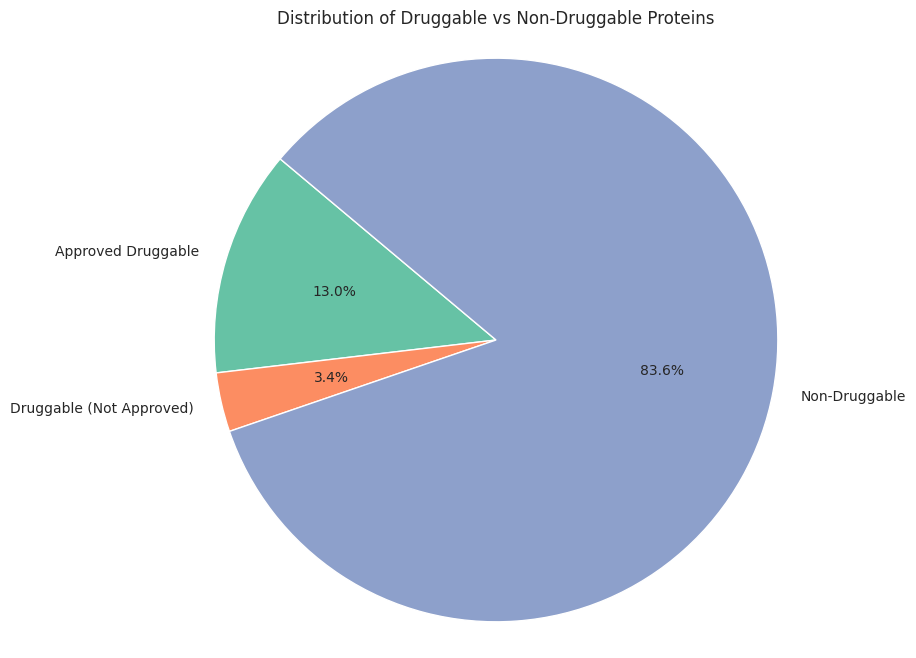

In [48]:
druggable_counts = properties['is_druggable'].value_counts()

druggable_df = properties[properties['is_druggable'] == 1]
approved_druggable_count = druggable_df['is_approved'].sum()

total_proteins = properties.shape[0]

non_druggable_count = total_proteins - druggable_counts[1]
non_approved_druggable_count = druggable_counts[1] - approved_druggable_count

# Plotting
plt.figure(figsize=(8, 8))
plt.pie([approved_druggable_count, non_approved_druggable_count, non_druggable_count], labels=['Approved Druggable', 'Druggable (Not Approved)', 'Non-Druggable'], autopct='%1.1f%%', startangle=140, colors=['#66c2a5', '#fc8d62', '#8da0cb'])
plt.title('Distribution of Druggable vs Non-Druggable Proteins')
plt.axis('equal')
plt.show()

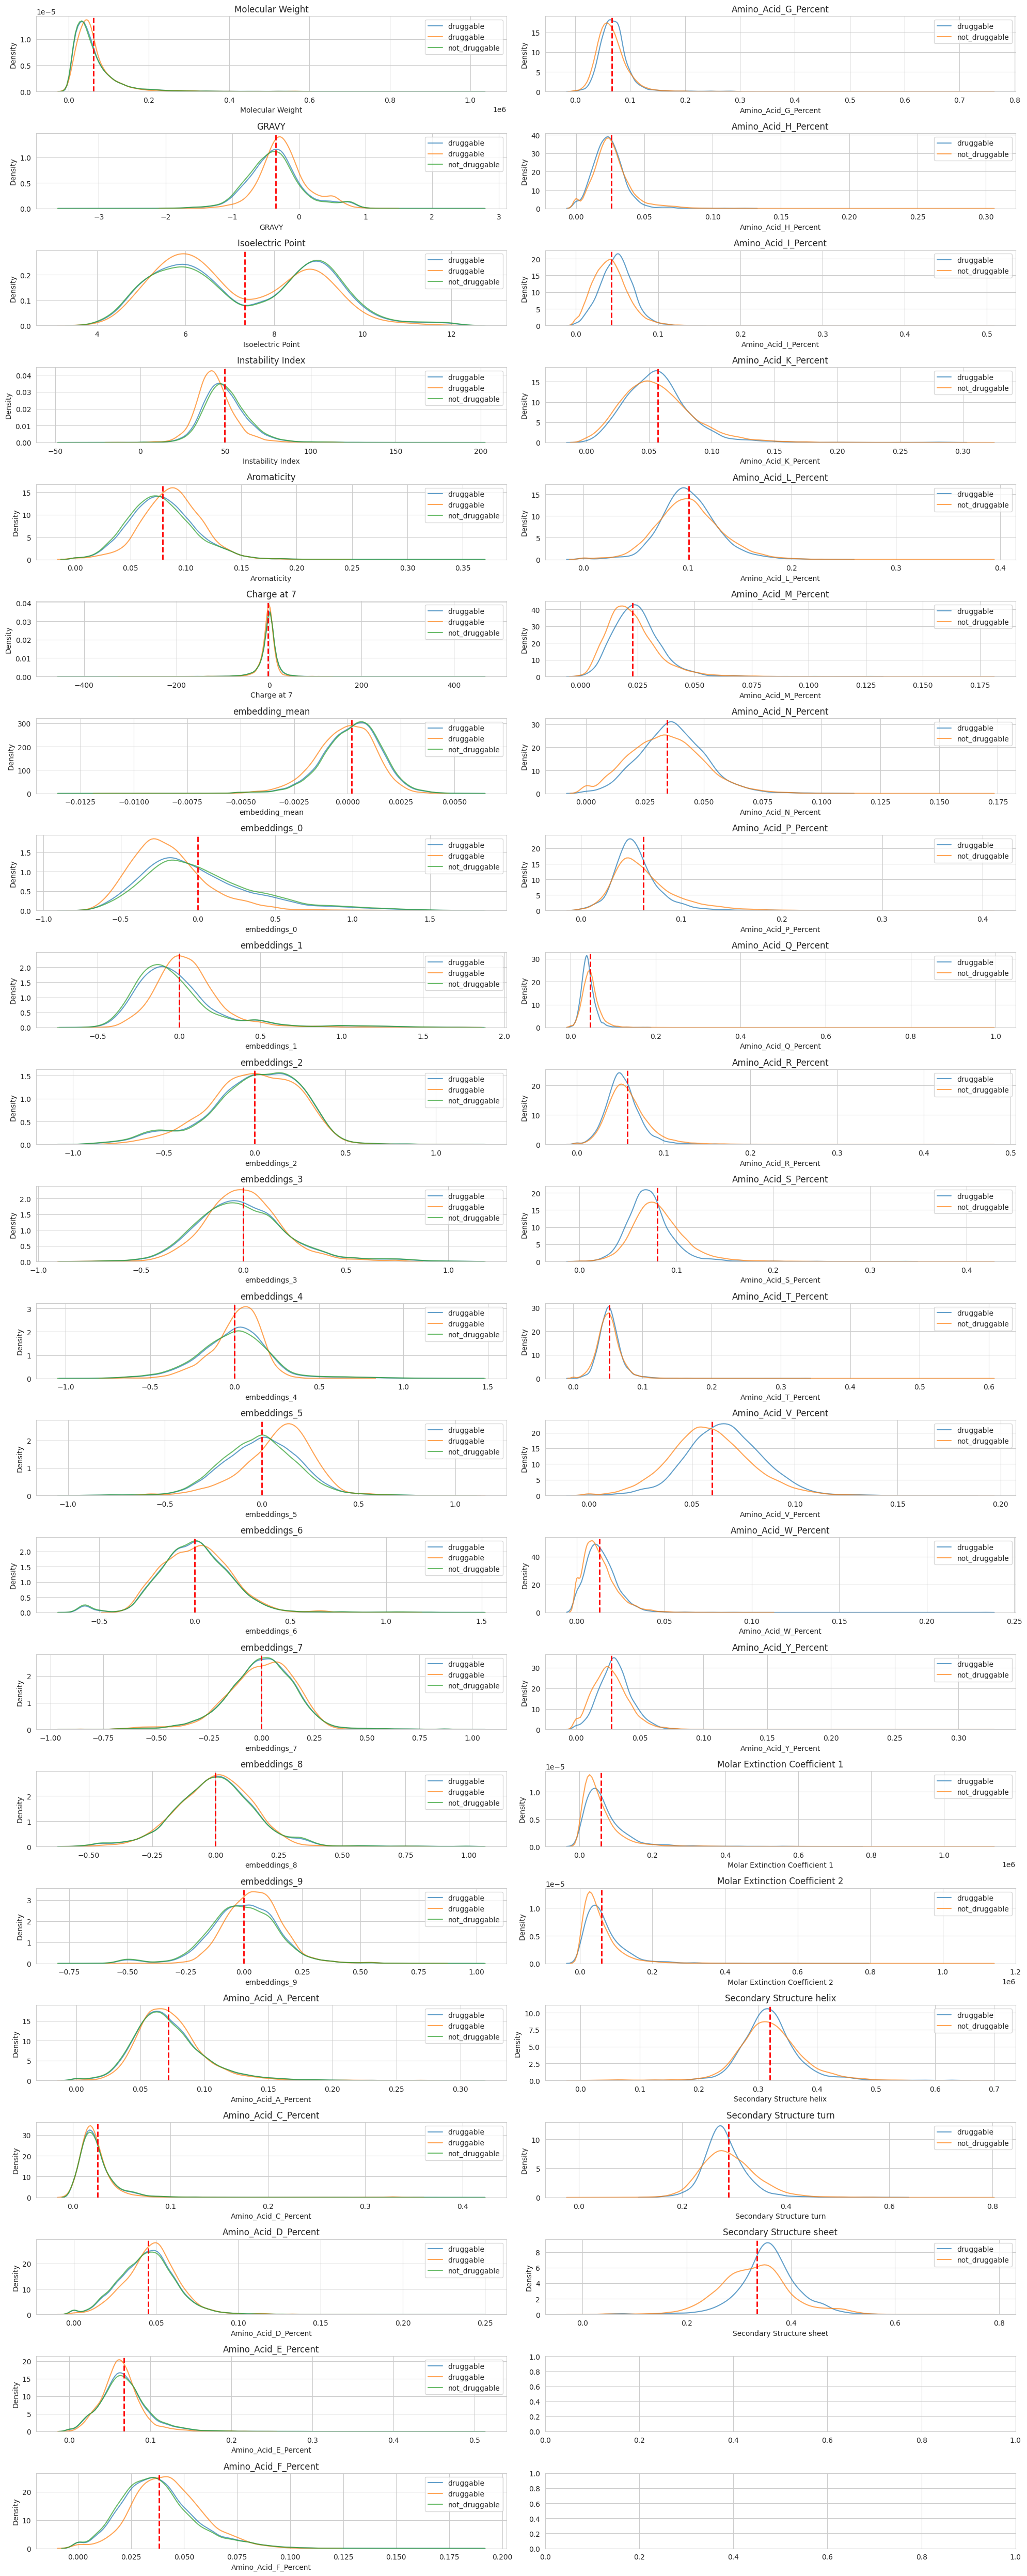

In [49]:
fig,ax = plt.subplots(figsize = (20,50),nrows = 22,ncols = 2)
okk = [i for i in data.columns if i!= "is_druggable" and i!= "is_approved" and i not in unique_groups_list]
for i,values in enumerate(okk):
  if i <22:
    sns.kdeplot(data=data, x=values, ax=ax[i][0],alpha = 0.7,common_norm = True, label = 'druggable')
    sns.kdeplot(data=data[data['is_druggable'] == 1], x=values, ax=ax[i][0],alpha = 0.7,common_norm = True, label = 'druggable')
    sns.kdeplot(data = data[data['is_druggable'] == 0], x=values, ax=ax[i][0],alpha = 0.7,common_norm = True, label ='not_druggable')
    ax[i][0].axvline(data[values].mean(), color='red', linestyle='dashed', linewidth=2)
    ax[i][0].set_title(values)
    ax[i][0].legend()
  else:
    sns.kdeplot(data=data[data['is_druggable'] == 1], x=values, ax=ax[i-22][1],alpha = 0.7,common_norm = True,label = 'druggable')
    sns.kdeplot(data=data[data['is_druggable'] == 0], x=values, ax=ax[i-22][1],alpha = 0.7,common_norm = True,label ='not_druggable')
    ax[i-22][1].axvline(data[values].mean(), color='red', linestyle='dashed', linewidth=2)
    ax[i-22][1].set_title(values)
    ax[i-22][1].legend()

plt.tight_layout()
plt.show()

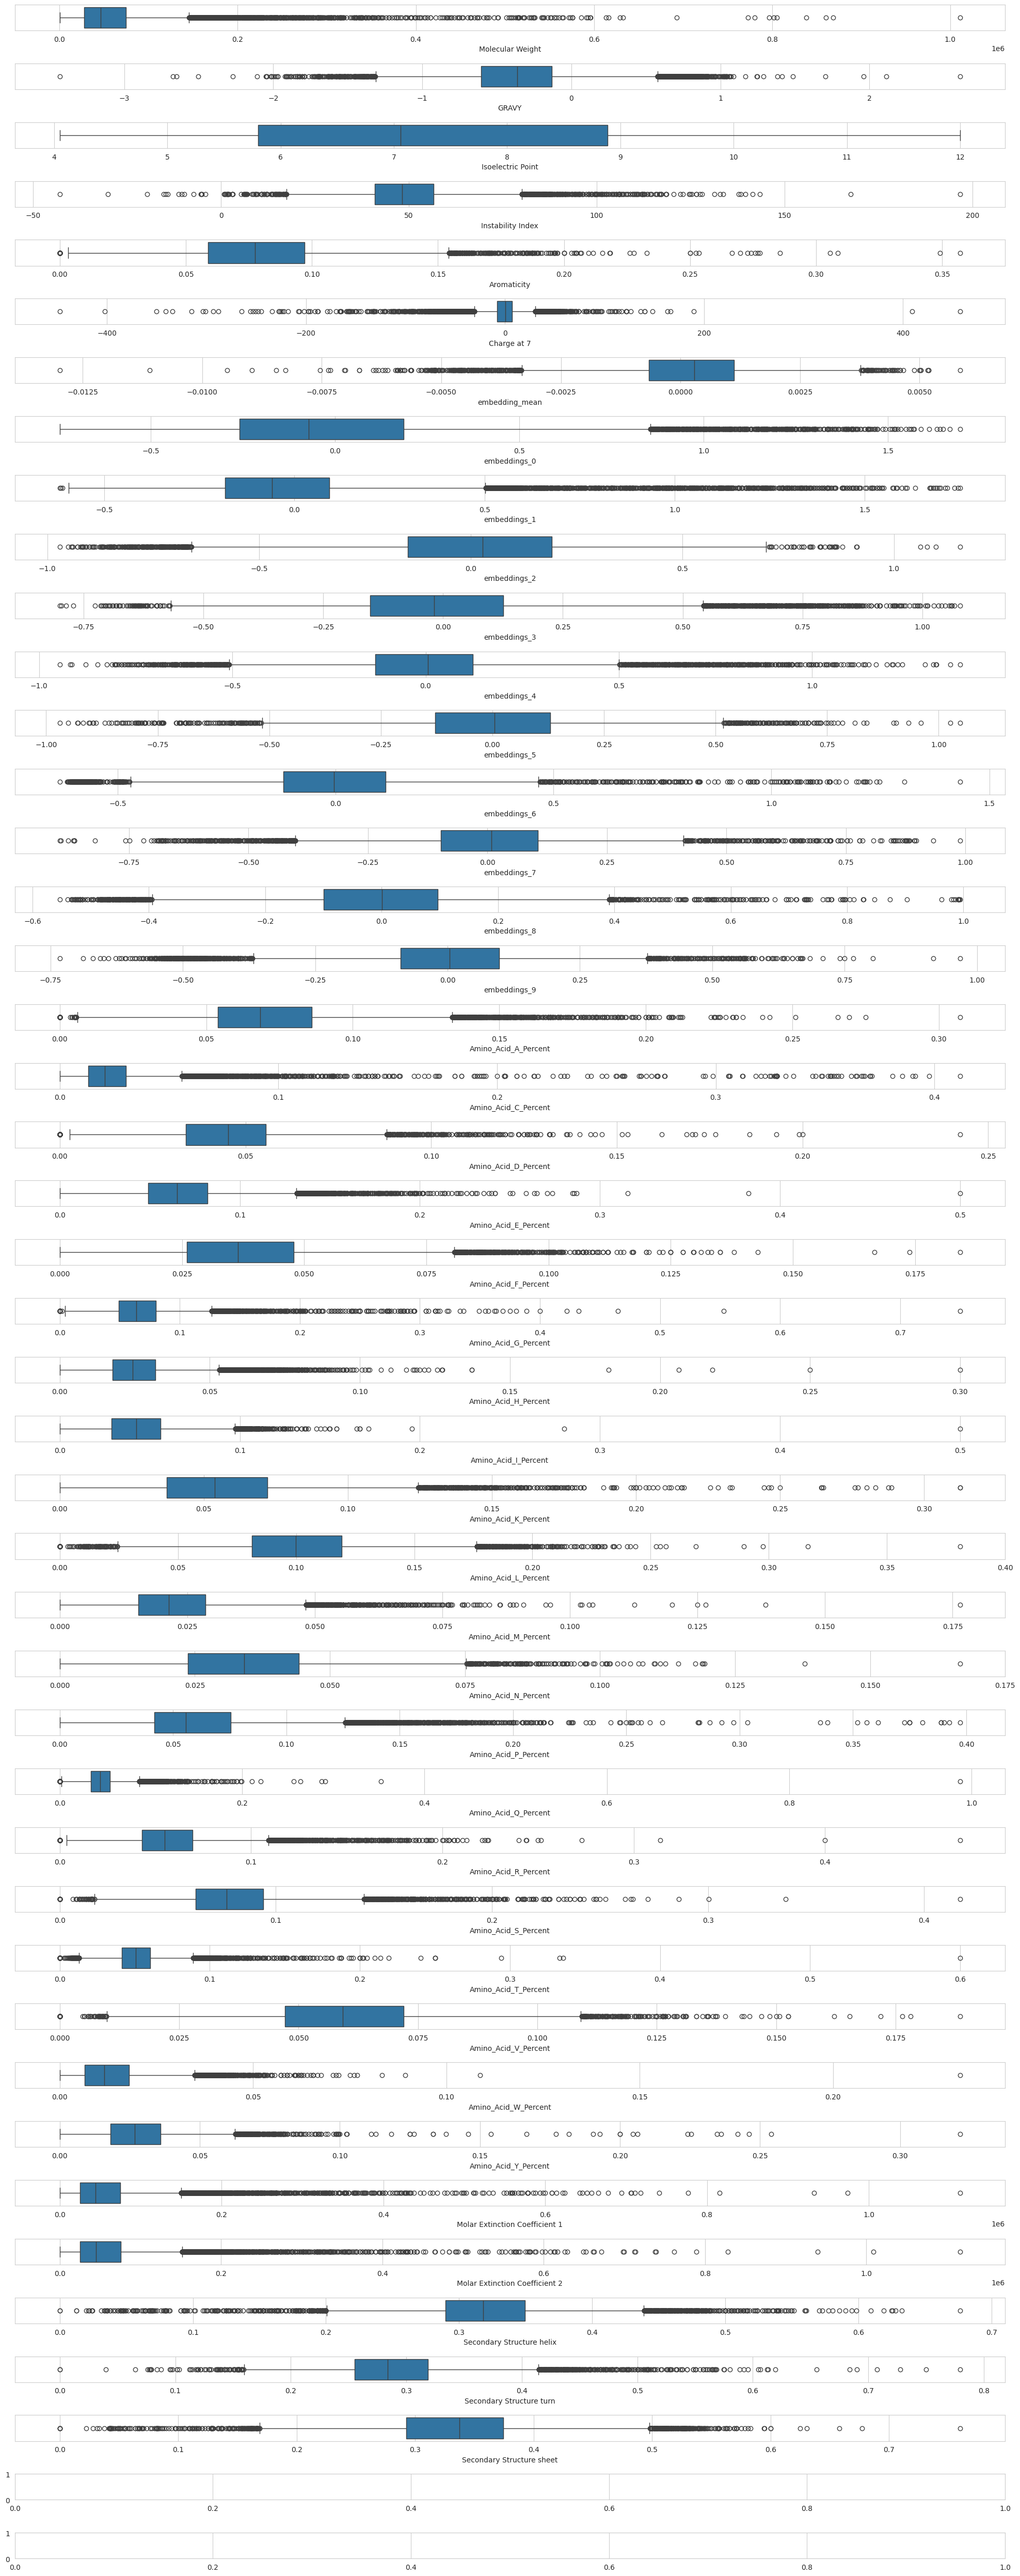

In [51]:
fig,ax = plt.subplots(figsize = (20,50), nrows = 44 )
for i,values in enumerate(okk):
  sns.boxplot(data[values], orient = 'h',ax = ax[i])
plt.tight_layout()
plt.show()

In [52]:
#scaling of data on same scale for further analysis(Z-score normalization)
std_scale = StandardScaler()
data[okk] = std_scale.fit_transform(data[okk])
data

Molecular Weight     GRAVY  Isoelectric Point  Instability Index  \
A0A087X1C5         -0.072800  0.760190           0.782941          -0.318816   
A0A0B4J2F0         -0.923385  0.251664           0.402109           0.456022   
A0A0B4J2F2          0.383305  0.338083          -0.294697           0.737113   
A0A0C5B5G6         -0.992175 -1.378626           1.673852           2.084725   
A0A0K2S4Q6         -0.665879  1.048210          -1.118990          -0.570007   
...                      ...       ...                ...                ...   
Q9UI54             -0.922166  1.502435           1.694652          -1.019198   
Q9UI72             -0.891207 -1.560714           1.150543          -0.242915   
Q9Y3F1             -0.919708  1.829755          -1.617143           1.514538   
Q9Y6C7             -0.845092  0.728456           1.631701           0.968746   
Q9Y6Z2             -0.925454 -0.179792          -0.767967           0.065820   

            Aromaticity  Charge at 7  embedding_mean  is_druggable  \
A0A087X1C5     0.206338     0.344723        0.155612             0   
A0A0B4J2F0     1.671388     0.105688       -0.876989             0   
A0A0B4J2F2    -0.509067     0.038364       -0.216114             0   
A0A0C5B5G6     5.661833     0.194116       -0.751805             0   
A0A0K2S4Q6    -0.152030    -0.067139        0.390163             0   
...                 ...          ...             ...           ...   
Q9UI54         2.196006     0.419486       -0.621858             0   
Q9UI72         0.737170     0.245617       -0.332199             0   
Q9Y3F1         3.885866    -0.028679       -0.246560             0   
Q9Y6C7         1.253404     0.357510        0.465342             0   
Q9Y6Z2         0.282003    -0.012756       -0.105217             0   

            is_approved  embeddings_0  ...  Amino_Acid_S_Percent  \
A0A087X1C5            0     -0.067566  ...             -1.172662   
A0A0B4J2F0            0     -0.620069  ...             -1.598492   
A0A0B4J2F2            0      0.186801  ...              0.197520   
A0A0C5B5G6            0      0.932802  ...             -2.969133   
A0A0K2S4Q6            0      0.546128  ...              0.713185   
...                 ...           ...  ...                   ...   
Q9UI54                0      2.116881  ...              1.068027   
Q9UI72                0      2.876118  ...             -1.896457   
Q9Y3F1                0      2.346401  ...              2.317624   
Q9Y6C7                0      2.558599  ...              0.180424   
Q9Y6Z2                0      2.150103  ...              0.926372   

            Amino_Acid_T_Percent  Amino_Acid_V_Percent  Amino_Acid_W_Percent  \
A0A087X1C5             -0.179218              1.300480              0.047543   
A0A0B4J2F0             -0.804703              0.721269             -1.394428   
A0A0B4J2F2              0.028378             -0.320350             -0.581494   
A0A0C5B5G6             -2.817983             -3.054601              5.236067   
A0A0K2S4Q6              1.779507              1.003050              1.244575   
...                          ...                   ...                   ...   
Q9UI54                  3.112041             -0.274188             -1.394428   
Q9UI72                 -0.454567             -2.315844              1.680584   
Q9Y3F1                  3.006148             -2.144347              2.394426   
Q9Y6C7                  0.651712             -1.427763              3.119951   
Q9Y6Z2                  0.996653             -0.371746              0.466763   

            Amino_Acid_Y_Percent  Molar Extinction Coefficient 1  \
A0A087X1C5             -1.071705                       -0.198160   
A0A0B4J2F0              0.603623                       -0.950950   
A0A0B4J2F2             -0.492042                       -0.039001   
A0A0C5B5G6              6.408541                       -0.857825   
A0A0K2S4Q6             -0.527264                       -0.434868   
...                     

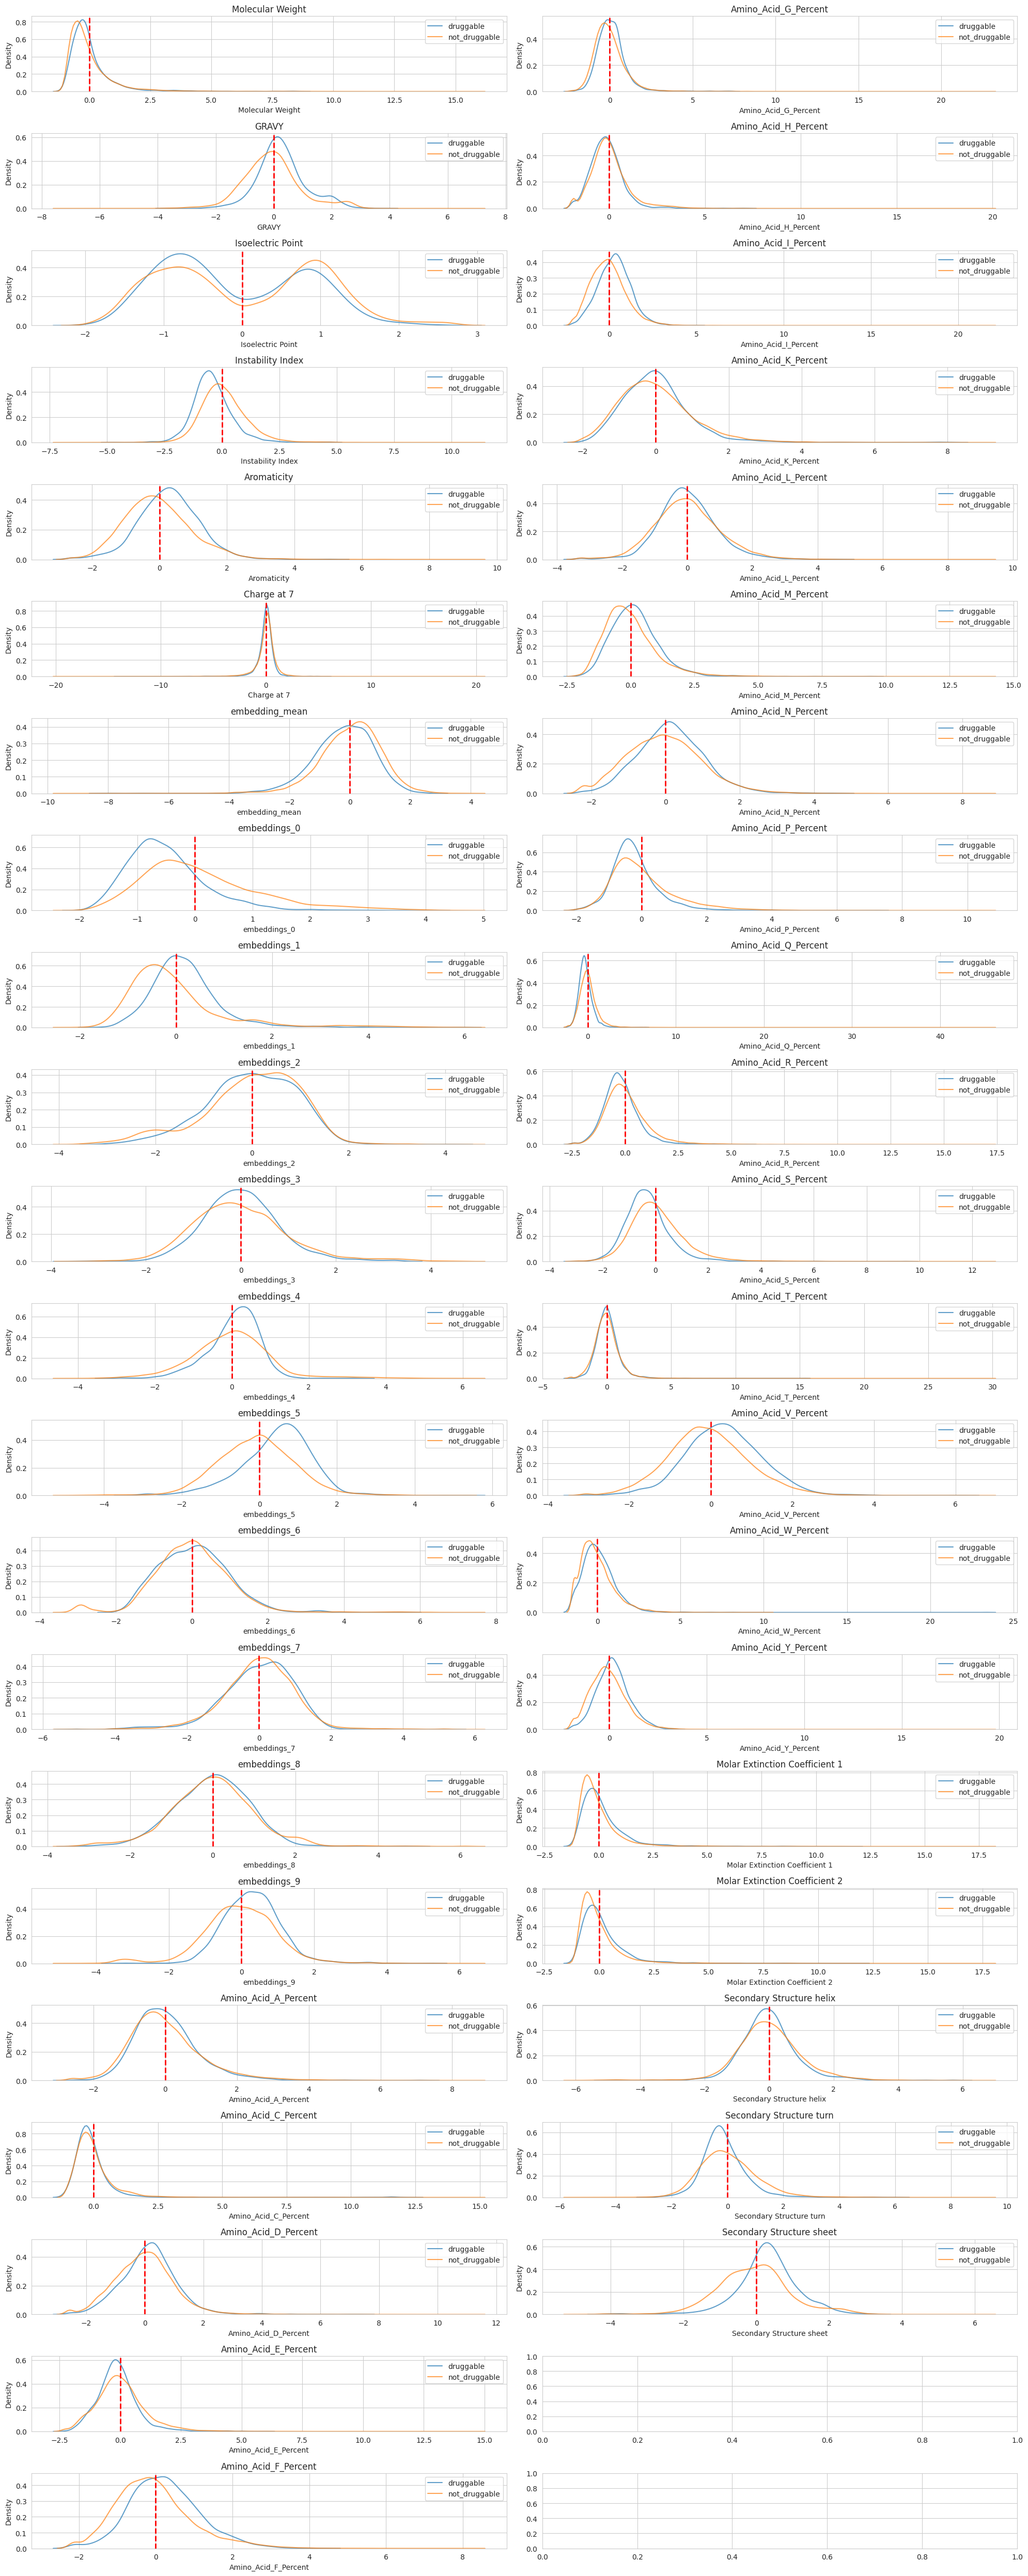

In [53]:
fig,ax = plt.subplots(figsize = (20,50),nrows = 22,ncols = 2)
for i,values in enumerate(okk):
  if i <22:
    sns.kdeplot(data=data[data['is_druggable'] == 1], x=values, ax=ax[i][0],alpha = 0.7,common_norm = True, label = 'druggable')
    sns.kdeplot(data = data[data['is_druggable'] == 0], x=values, ax=ax[i][0],alpha = 0.7,common_norm = True, label ='not_druggable')
    ax[i][0].axvline(data[values].mean(), color='red', linestyle='dashed', linewidth=2)
    ax[i][0].set_title(values)
    ax[i][0].legend()
  else:
    sns.kdeplot(data=data[data['is_druggable'] == 1], x=values, ax=ax[i-22][1],alpha = 0.7,common_norm = True,label = 'druggable')
    sns.kdeplot(data=data[data['is_druggable'] == 0], x=values, ax=ax[i-22][1],alpha = 0.7,common_norm = True,label ='not_druggable')
    ax[i-22][1].axvline(data[values].mean(), color='red', linestyle='dashed', linewidth=2)
    ax[i-22][1].set_title(values)
    ax[i-22][1].legend()

plt.tight_layout()
plt.show()

In [54]:
#lets fix imbalance in data by upsampling using SMOTE(most reliable)
#approved_drug = 13%
#not approved but druggable = 3.4%
#non_druggable = 83.6%

# x = data.drop(columns = ['is_druggable','is_approved'])
# y = data['is_druggable']
# oversample = SMOTE()
# x_up,y_up = oversample.fit_resample(x,y)
# okk_1 = pd.DataFrame(x_up)
# okk_2 = pd.DataFrame(y_up)
# okk_1['is_druggable'] = okk_2
# okk_1

In [55]:
# druggable_counts = okk_1['is_druggable'].value_counts()
# druggable_count = druggable_counts[1]
# non_druggable_count = druggable_counts[0]

# # Plotting
# plt.figure(figsize=(8, 8))
# plt.pie([druggable_count, non_druggable_count], labels=['Druggable', 'Non-Druggable'], autopct='%1.1f%%', startangle=140, colors=['#66c2a5', '#fc8d62'])
# plt.title('Distribution of Druggable vs Non-Druggable Protein Using SMOTE Technique')
# plt.axis('equal')
# plt.show()

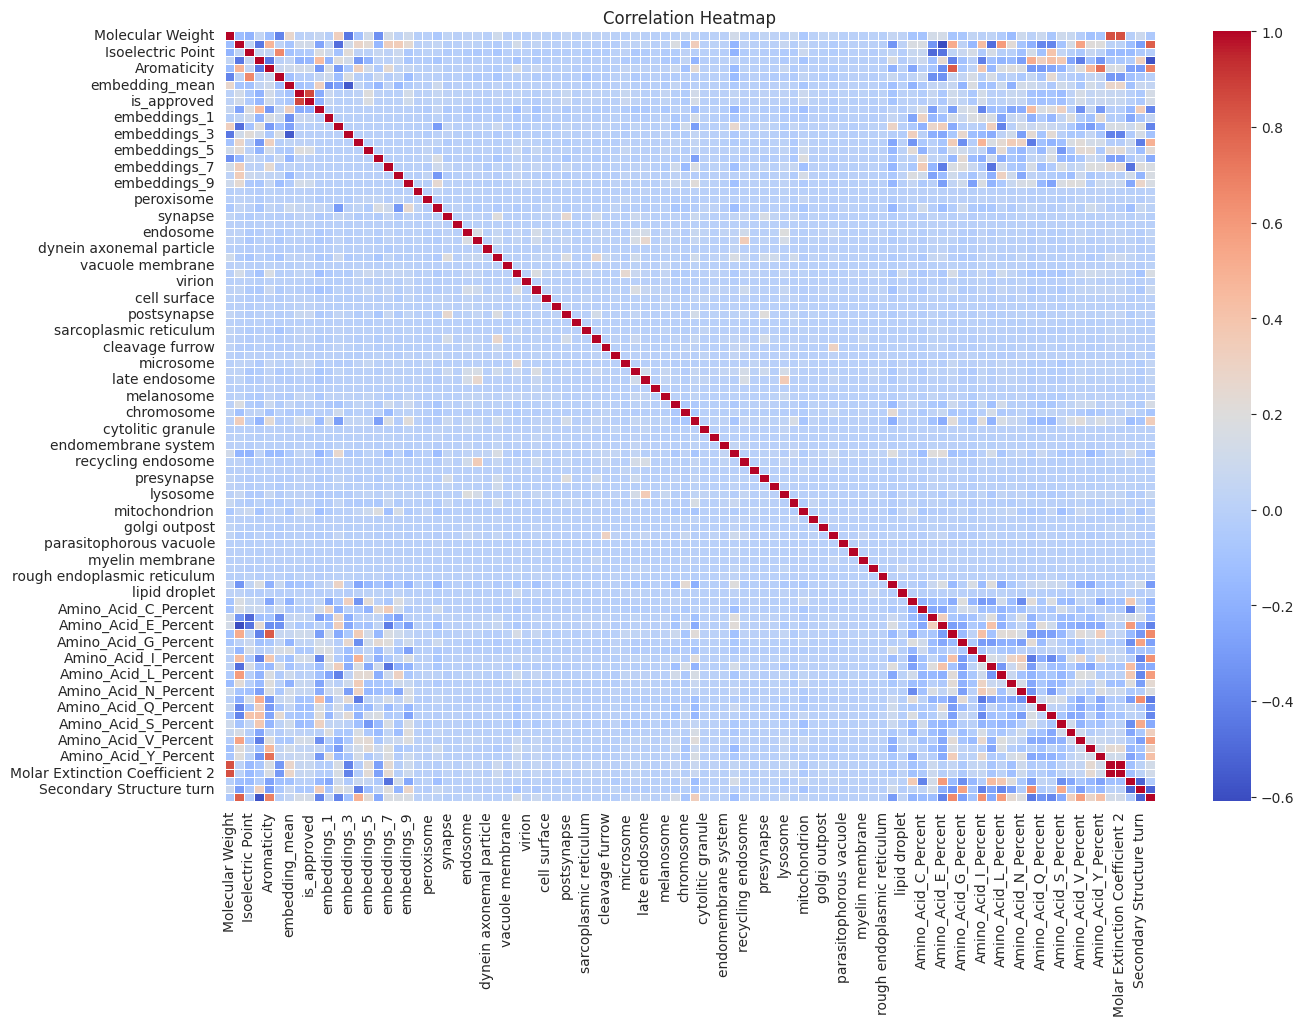

In [56]:
okk_1 = data.copy()
plt.figure(figsize=(15, 10))
sns.heatmap(okk_1.corr(), cmap='coolwarm', annot=False, fmt=".2f",linewidth= 0.5)
plt.title('Correlation Heatmap')
plt.show()

In [65]:
location_data = okk_1.iloc[:,19:69]

n_components = 50
pca_list = []
feature_weight_list = []
for i in range(1,n_components):
  PCAmod = PCA(n_components = i)
  PCAmod.fit(location_data)
  pca_list.append(pd.Series({
      "n" : i,
      "model" : PCAmod,
      "var" : PCAmod.explained_variance_ratio_.sum(),
  }))
  weights = PCAmod.explained_variance_ratio_.reshape(-1, 1) / PCAmod.explained_variance_ratio_.sum()
  overall_contributions = np.abs(PCAmod.components_) * weights
  abs_feature_values = overall_contributions.sum(axis=0)
  feature_weight_list.append(pd.DataFrame({
      'n': i,
      'features': location_data.columns,
      'values': abs_feature_values / abs_feature_values.sum(),
  }))
pca_report = pd.DataFrame(pca_list)
feature_importance_report = pd.concat(feature_weight_list).pivot(index='n', columns='features', values='values')

In [66]:
pca_report

n                 model       var
0    1   PCA(n_components=1)  0.226165
1    2   PCA(n_components=2)  0.376399
2    3   PCA(n_components=3)  0.496172
3    4   PCA(n_components=4)  0.574321
4    5   PCA(n_components=5)  0.639989
5    6   PCA(n_components=6)  0.695296
6    7   PCA(n_components=7)  0.740939
7    8   PCA(n_components=8)  0.781687
8    9   PCA(n_components=9)  0.817656
9   10  PCA(n_components=10)  0.844329
10  11  PCA(n_components=11)  0.866740
11  12  PCA(n_components=12)  0.884948
12  13  PCA(n_components=13)  0.899798
13  14  PCA(n_components=14)  0.911750
14  15  PCA(n_components=15)  0.923288
15  16  PCA(n_components=16)  0.933270
16  17  PCA(n_components=17)  0.940555
17  18  PCA(n_components=18)  0.946195
18  19  PCA(n_components=19)  0.950986
19  20  PCA(n_components=20)  0.955660
20  21  PCA(n_components=21)  0.960072
21  22  PCA(n_components=22)  0.964354
22  23  PCA(n_components=23)  0.968512
23  24  PCA(n_components=24)  0.972412
24  25  PCA(n_components=25)  0.975945
25  26  PCA(n_components=26)  0.979316
26  27  PCA(n_components=27)  0.982415
27  28  PCA(n_components=28)  0.985072
28  29  PCA(n_components=29)  0.987338
29  30  PCA(n_components=30)  0.989434
30  31  PCA(n_components=31)  0.991085
31  32  PCA(n_components=32)  0.992541
32  33  PCA(n_components=33)  0.993683
33  34  PCA(n_components=34)  0.994726
34  35  PCA(n_components=35)  0.995605
35  36  PCA(n_components=36)  0.996263
36  37  PCA(n_components=37)  0.996792
37  38  PCA(n_components=38)  0.997273
38  39  PCA(n_components=39)  0.997713
39  40  PCA(n_components=40)  0.998152
40  41  PCA(n_components=41)  0.998548
41  42  PCA(n_components=42)  0.998943
42  43  PCA(n_components=43)  0.999208
43  44  PCA(n_components=44)  0.999428
44  45  PCA(n_components=45)  0.999648
45  46  PCA(n_components=46)  0.999779
46  47  PCA(n_components=47)  0.999868
47  48  PCA(n_components=48)  0.999912
48  49  PCA(n_components=49)  0.999956

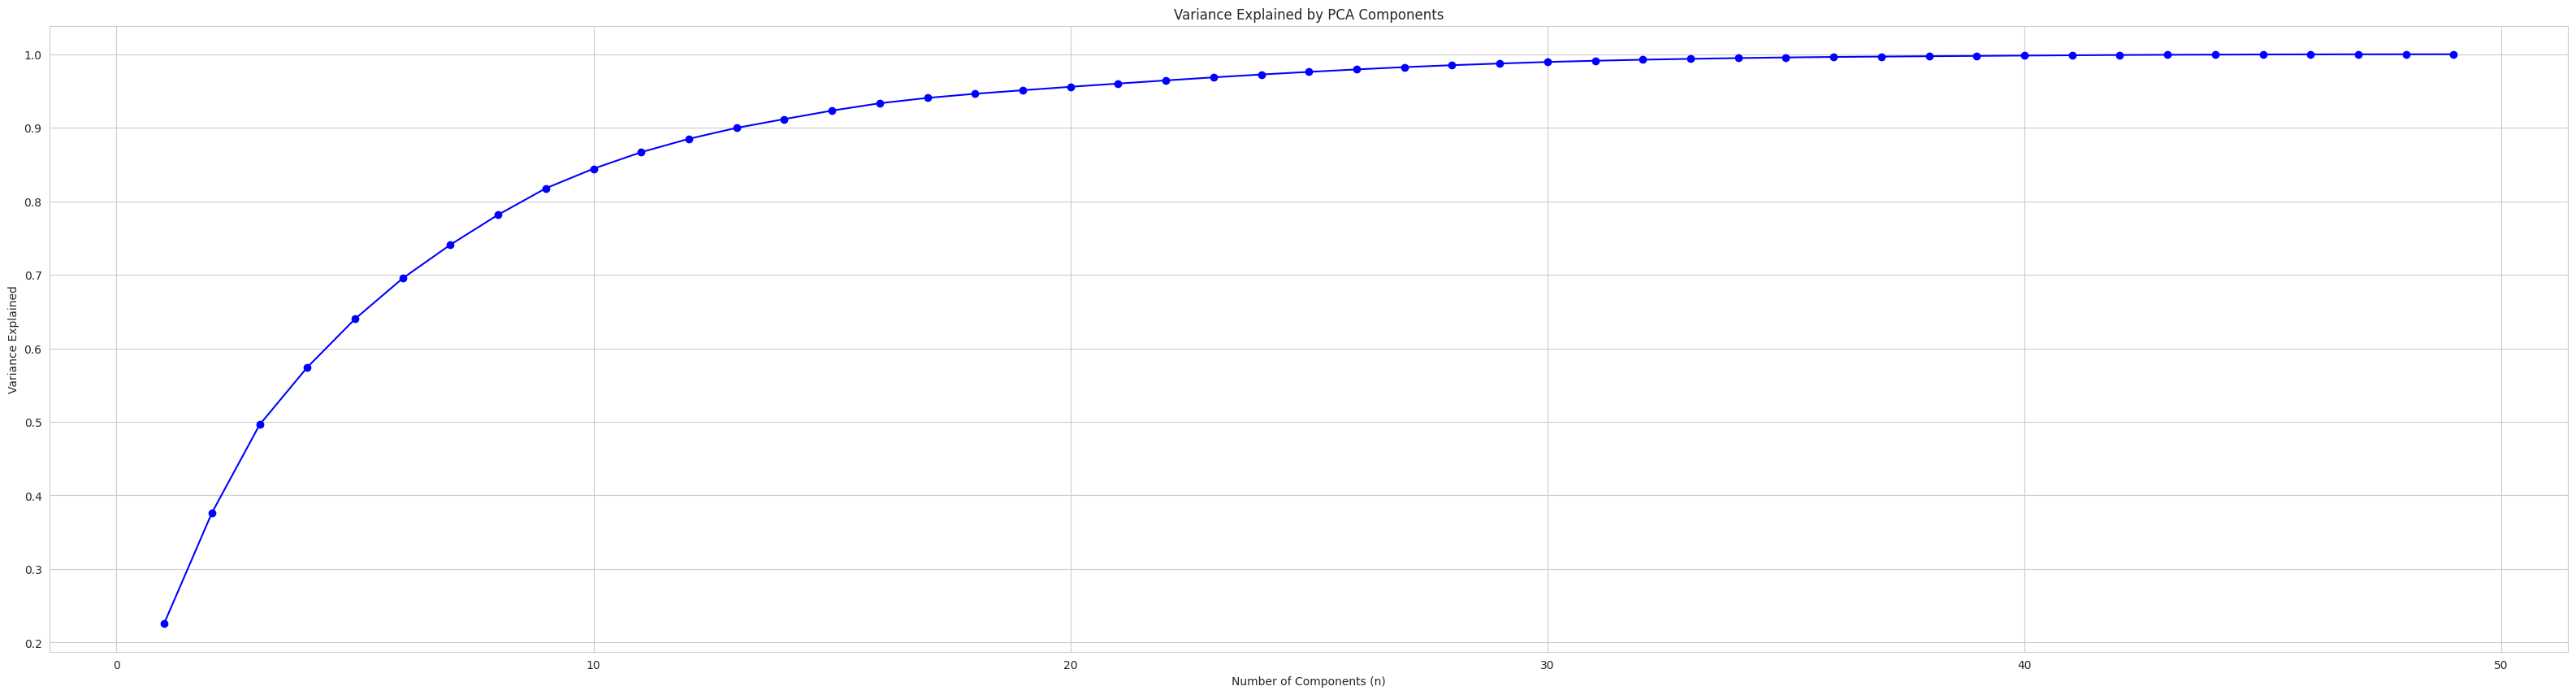

In [67]:
fig,ax = plt.subplots(figsize = (40,10))
plt.plot(pca_report['n'], pca_report['var'], marker = 'o', linestyle = "-", color = 'b')
plt.title('Variance Explained by PCA Components')
# plt.axvline(x=150, color='r', linestyle='--', linewidth=2, label='Threshold at x=50')
plt.xlabel('Number of Components (n)')
plt.ylabel('Variance Explained')
plt.grid(True)
plt.show()

[Text(0.5, 0, 'Number of components'),
 Text(0, 0.5, 'Relative Importance'),
 Text(0.5, 1.0, 'Feature Importance Vs Dimensions')]

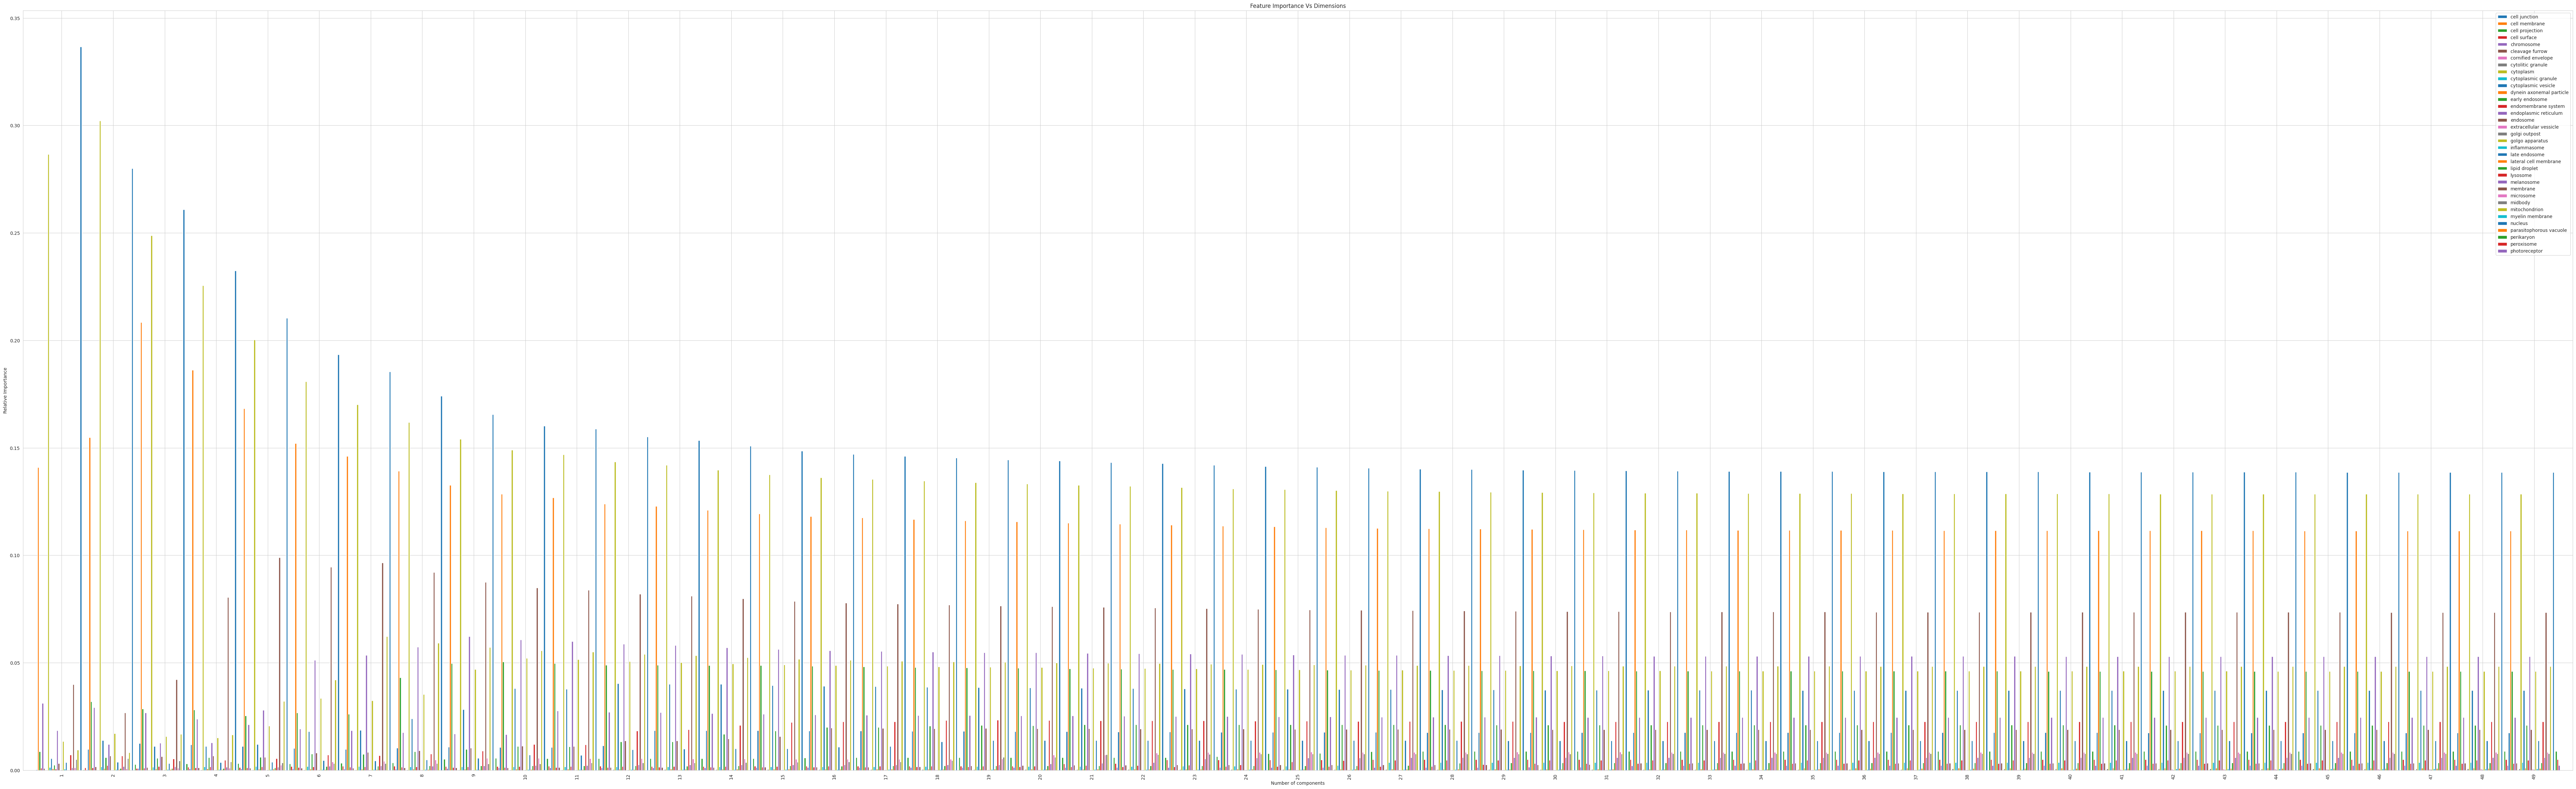

In [71]:
ax = feature_importance_report.iloc[:,:35].plot(kind = 'bar' , figsize = (100,30), width=1)
ax.legend(loc = 'upper right')
ax.set(xlabel = 'Number of components' ,  ylabel = 'Relative Importance' , title = 'Feature Importance Vs Dimensions')

<Figure size 2000x1200 with 0 Axes>

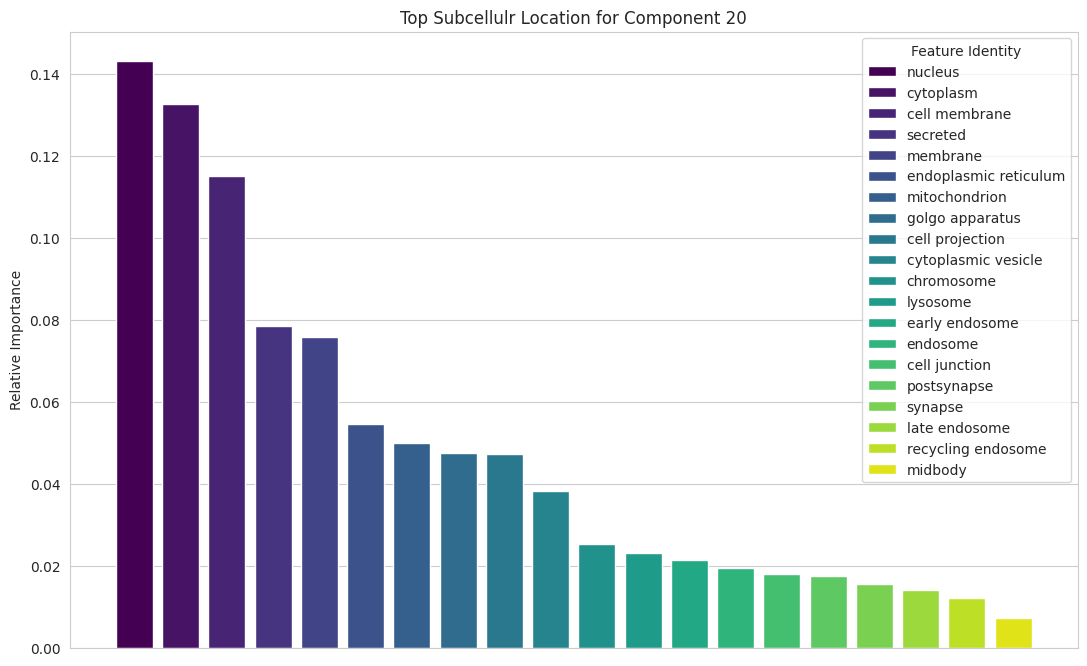

In [74]:
plt.figure(figsize= (20,12))
n_top_features = 20
top_features = feature_importance_report.iloc[20].nlargest(n_top_features)
fig, ax = plt.subplots(figsize=(13, 8))

for idx, (feature, importance) in enumerate(top_features.items()):
    ax.bar(idx, importance, label=feature, color=plt.cm.viridis(idx / len(top_features)))

ax.set_xticks([])

ax.legend(loc='upper right', title='Feature Identity')

ax.set(ylabel='Relative Importance', title='Top Subcellulr Location for Component 20')
plt.show()

In [86]:
#dimensional reduction of subcelluar on-hot encoded features

pca_model = PCA(n_components = 20)
yh = pca_model.fit_transform(location_data)
okk_1 = pd.concat([okk_1, pd.DataFrame(yh, columns=[f'Subcellular_PCA_{i+1}' for i in range(20)], index=okk_1.index)], axis=1)
okk_1

Molecular Weight     GRAVY  Isoelectric Point  Instability Index  \
A0A087X1C5         -0.072800  0.760190           0.782941          -0.318816   
A0A0B4J2F0         -0.923385  0.251664           0.402109           0.456022   
A0A0B4J2F2          0.383305  0.338083          -0.294697           0.737113   
A0A0C5B5G6         -0.992175 -1.378626           1.673852           2.084725   
A0A0K2S4Q6         -0.665879  1.048210          -1.118990          -0.570007   
...                      ...       ...                ...                ...   
Q9UI54             -0.922166  1.502435           1.694652          -1.019198   
Q9UI72             -0.891207 -1.560714           1.150543          -0.242915   
Q9Y3F1             -0.919708  1.829755          -1.617143           1.514538   
Q9Y6C7             -0.845092  0.728456           1.631701           0.968746   
Q9Y6Z2             -0.925454 -0.179792          -0.767967           0.065820   

            Aromaticity  Charge at 7  embedding_mean  is_druggable  \
A0A087X1C5     0.206338     0.344723        0.155612             0   
A0A0B4J2F0     1.671388     0.105688       -0.876989             0   
A0A0B4J2F2    -0.509067     0.038364       -0.216114             0   
A0A0C5B5G6     5.661833     0.194116       -0.751805             0   
A0A0K2S4Q6    -0.152030    -0.067139        0.390163             0   
...                 ...          ...             ...           ...   
Q9UI54         2.196006     0.419486       -0.621858             0   
Q9UI72         0.737170     0.245617       -0.332199             0   
Q9Y3F1         3.885866    -0.028679       -0.246560             0   
Q9Y6C7         1.253404     0.357510        0.465342             0   
Q9Y6Z2         0.282003    -0.012756       -0.105217             0   

            is_approved  embeddings_0  ...  Subcellular_PCA_11  \
A0A087X1C5            0     -0.067566  ...            0.042627   
A0A0B4J2F0            0     -0.620069  ...            0.009269   
A0A0B4J2F2            0      0.186801  ...           -0.013620   
A0A0C5B5G6            0      0.932802  ...           -0.073002   
A0A0K2S4Q6            0      0.546128  ...           -0.013620   
...                 ...           ...  ...                 ...   
Q9UI54                0      2.116881  ...           -0.013620   
Q9UI72                0      2.876118  ...           -0.013620   
Q9Y3F1                0      2.346401  ...           -0.013620   
Q9Y6C7                0      2.558599  ...           -0.013620   
Q9Y6Z2                0      2.150103  ...           -0.013620   

            Subcellular_PCA_12  Subcellular_PCA_13  Subcellular_PCA_14  \
A0A087X1C5            0.000857           -0.022258           -0.016015   
A0A0B4J2F0           -0.006854            0.007028            0.005753   
A0A0B4J2F2           -0.013103           -0.000518            0.005258   
A0A0C5B5G6            0.010746            0.013184            0.009233   
A0A0K2S4Q6           -0.013103           -0.000518            0.005258   
...                        ...                 ...                 ...   
Q9UI54               -0.013103           -0.000518            0.005258   
Q9UI72               -0.013103           -0.000518            0.005258   
Q9Y3F1               -0.013103           -0.000518            0.005258   
Q9Y6C7               -0.013103           -0.000518            0.005258   
Q9Y6Z2               -0.013103           -0.000518            0.005258   

            Subcellular_PCA_15  Subcellular_PCA_16  Subcellular_PCA_17  \
A0A087X1C5            0.009193           -0.018743           -0.007026   
A0A0B4J2F0           -0.002523            0.004680            0.002560   
A0A0B4J2F2           -0.005131            0.007472            0.002239   
A0A0C5B5G6           -0.001097           -0.009908           -0.008841   
A0A0K2S4Q6           -0.005131            0.007472            0.002239   
...                        ...                 ...                 ...   
Q9UI54    

In [87]:
okk_1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20431 entries, A0A087X1C5 to Q9Y6Z2
Data columns (total 63 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Molecular Weight                20431 non-null  float64
 1   GRAVY                           20431 non-null  float64
 2   Isoelectric Point               20431 non-null  float64
 3   Instability Index               20431 non-null  float64
 4   Aromaticity                     20431 non-null  float64
 5   Charge at 7                     20431 non-null  float64
 6   embedding_mean                  20431 non-null  float64
 7   is_druggable                    20431 non-null  int64  
 8   is_approved                     20431 non-null  int64  
 9   embeddings_0                    20431 non-null  float64
 10  embeddings_1                    20431 non-null  float64
 11  embeddings_2                    20431 non-null  float64
 12  embeddings_3               

In [88]:
#PCA Analysis for reduction and selection of relevant ones

n_components = 63
pca_list = []
feature_weight_list = []
for i in range(1,n_components):
  PCAmod = PCA(n_components = i)
  PCAmod.fit(okk_1)
  pca_list.append(pd.Series({
      "n" : i,
      "model" : PCAmod,
      "var" : PCAmod.explained_variance_ratio_.sum(),
  }))
  weights = PCAmod.explained_variance_ratio_.reshape(-1, 1) / PCAmod.explained_variance_ratio_.sum()
  overall_contributions = np.abs(PCAmod.components_) * weights
  abs_feature_values = overall_contributions.sum(axis=0)
  feature_weight_list.append(pd.DataFrame({
      'n': i,
      'features': okk_1.columns,
      'values': abs_feature_values / abs_feature_values.sum(),
  }))
pca_report = pd.DataFrame(pca_list)
feature_importance_report = pd.concat(feature_weight_list).pivot(index='n', columns='features', values='values')

In [89]:
pca_report

n                 model       var
0    1   PCA(n_components=1)  0.160458
1    2   PCA(n_components=2)  0.265625
2    3   PCA(n_components=3)  0.358866
3    4   PCA(n_components=4)  0.423299
4    5   PCA(n_components=5)  0.477866
..  ..                   ...       ...
57  58  PCA(n_components=58)  1.000000
58  59  PCA(n_components=59)  1.000000
59  60  PCA(n_components=60)  1.000000
60  61  PCA(n_components=61)  1.000000
61  62  PCA(n_components=62)  1.000000

[62 rows x 3 columns]

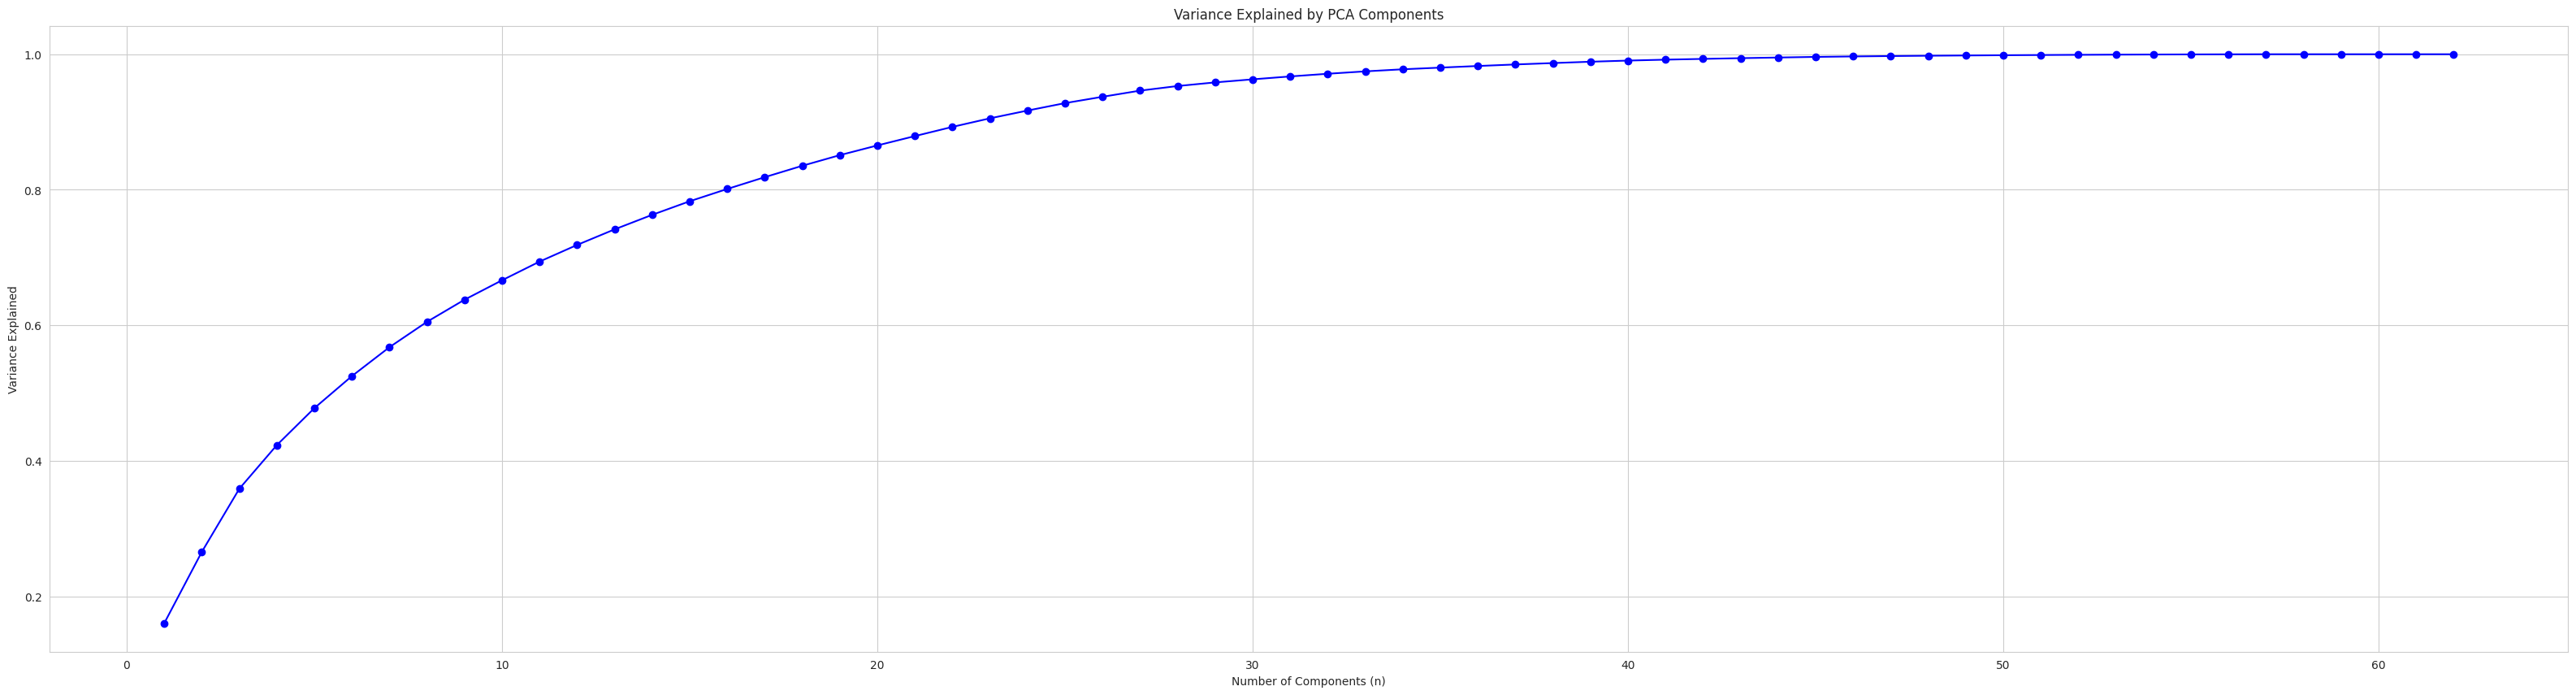

In [90]:
fig,ax = plt.subplots(figsize = (40,10))
plt.plot(pca_report['n'], pca_report['var'], marker = 'o', linestyle = "-", color = 'b')
plt.title('Variance Explained by PCA Components')
# plt.axvline(x=150, color='r', linestyle='--', linewidth=2, label='Threshold at x=50')
plt.xlabel('Number of Components (n)')
plt.ylabel('Variance Explained')
plt.grid(True)
plt.show()

[Text(0.5, 0, 'Number of components'),
 Text(0, 0.5, 'Relative Importance'),
 Text(0.5, 1.0, 'Feature Importance Vs Dimensions')]

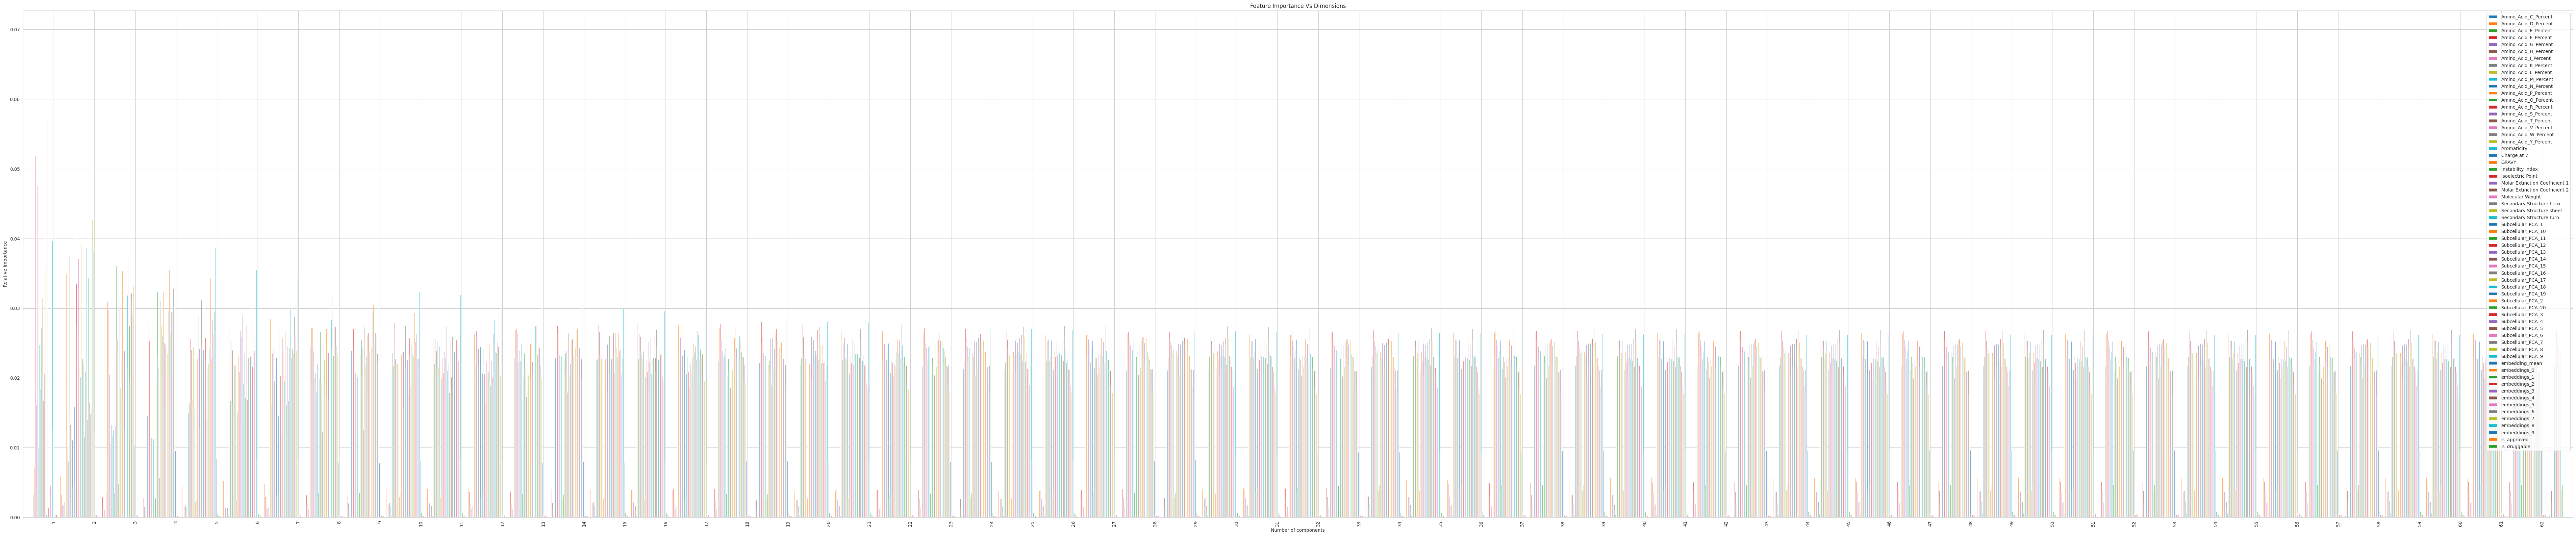

In [91]:
ax = feature_importance_report.plot(kind = 'bar' , figsize = (100,20), width=1)
ax.legend(loc = 'upper right')
ax.set(xlabel = 'Number of components' ,  ylabel = 'Relative Importance' , title = 'Feature Importance Vs Dimensions')

<Figure size 2000x1200 with 0 Axes>

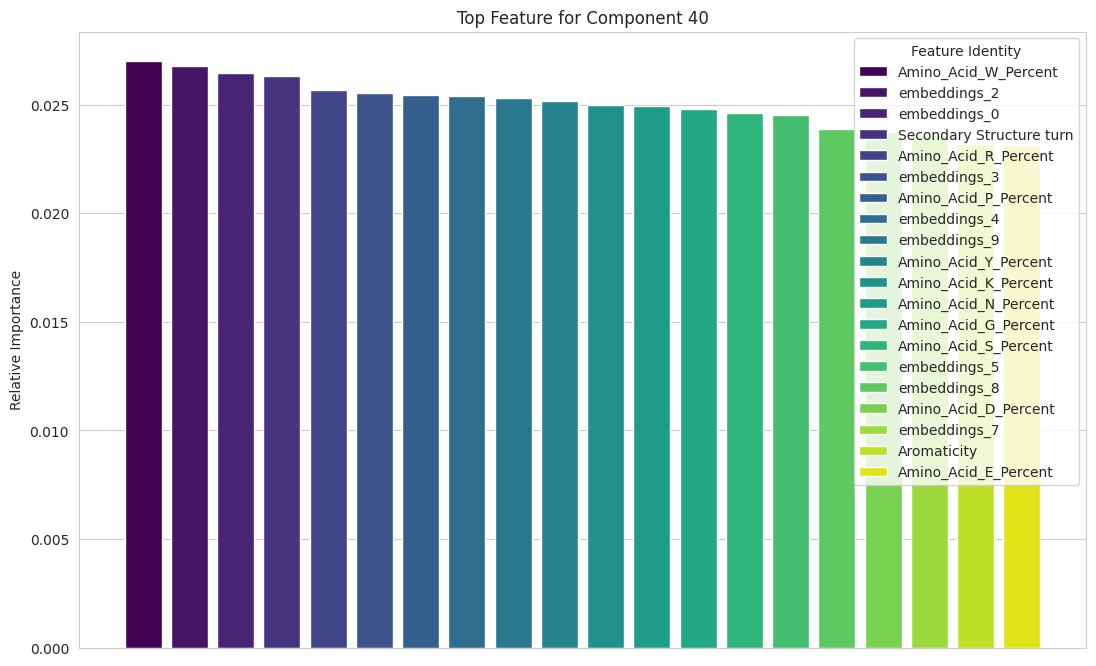

In [94]:
plt.figure(figsize= (20,12))
n_top_features = 20
top_features = feature_importance_report.iloc[39].nlargest(n_top_features)
fig, ax = plt.subplots(figsize=(13, 8))

for idx, (feature, importance) in enumerate(top_features.items()):
    ax.bar(idx, importance, label=feature, color=plt.cm.viridis(idx / len(top_features)))

ax.set_xticks([])

ax.legend(loc='upper right', title='Feature Identity')

ax.set(ylabel='Relative Importance', title='Top Feature for Component 40')
plt.show()

<Figure size 2000x1200 with 0 Axes>

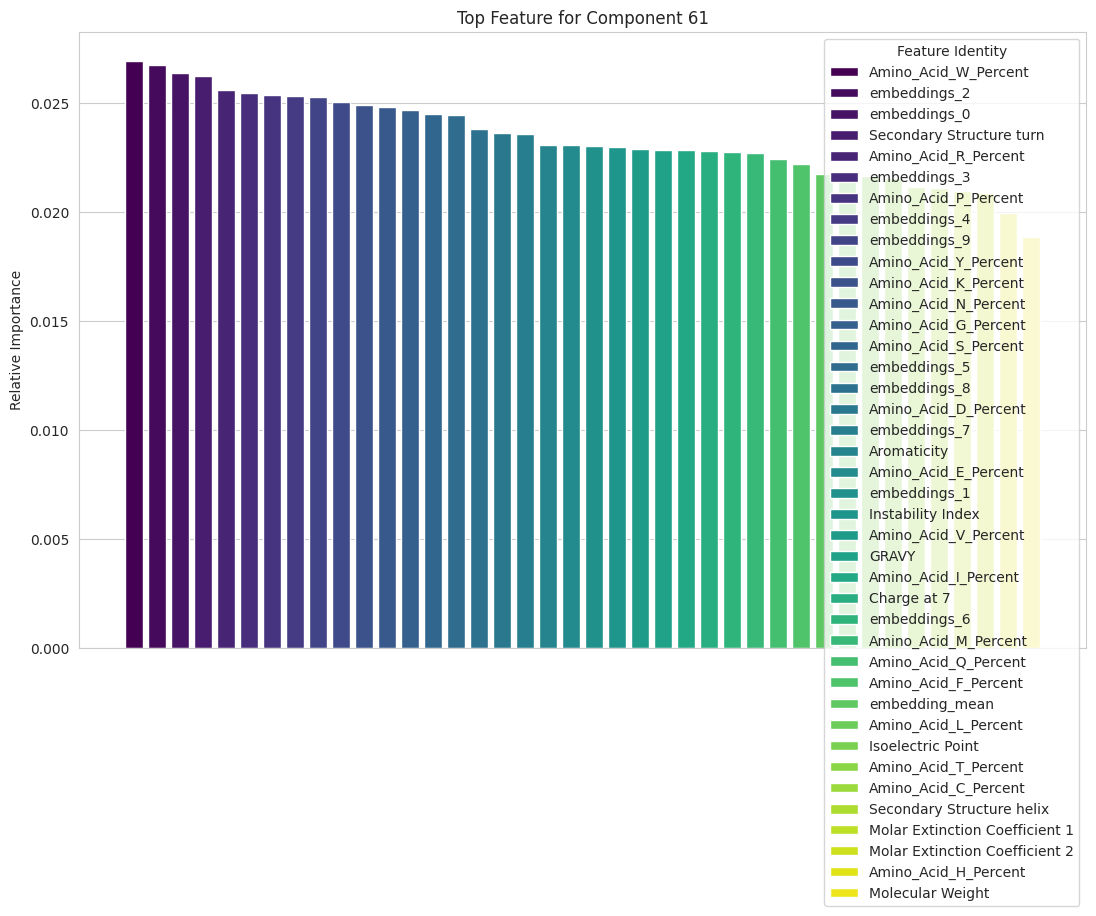

In [95]:
plt.figure(figsize= (20,12))
n_top_features = 40
top_features = feature_importance_report.iloc[61].nlargest(n_top_features)
fig, ax = plt.subplots(figsize=(13, 8))

for idx, (feature, importance) in enumerate(top_features.items()):
    ax.bar(idx, importance, label=feature, color=plt.cm.viridis(idx / len(top_features)))

ax.set_xticks([])

ax.legend(loc='upper right', title='Feature Identity')

ax.set(ylabel='Relative Importance', title='Top Feature for Component 61')
plt.show()

Subcellular_PCA_18                0.007985
Subcellular_PCA_11                0.008554
Isoelectric Point                 0.009104
Amino_Acid_T_Percent              0.009981
Molar Extinction Coefficient 1    0.010336
                                    ...   
Subcellular_PCA_7                 0.030260
Subcellular_PCA_2                 0.040060
embeddings_1                      0.041957
embeddings_5                      0.045574
embeddings_0                      0.060126
Length: 61, dtype: float32


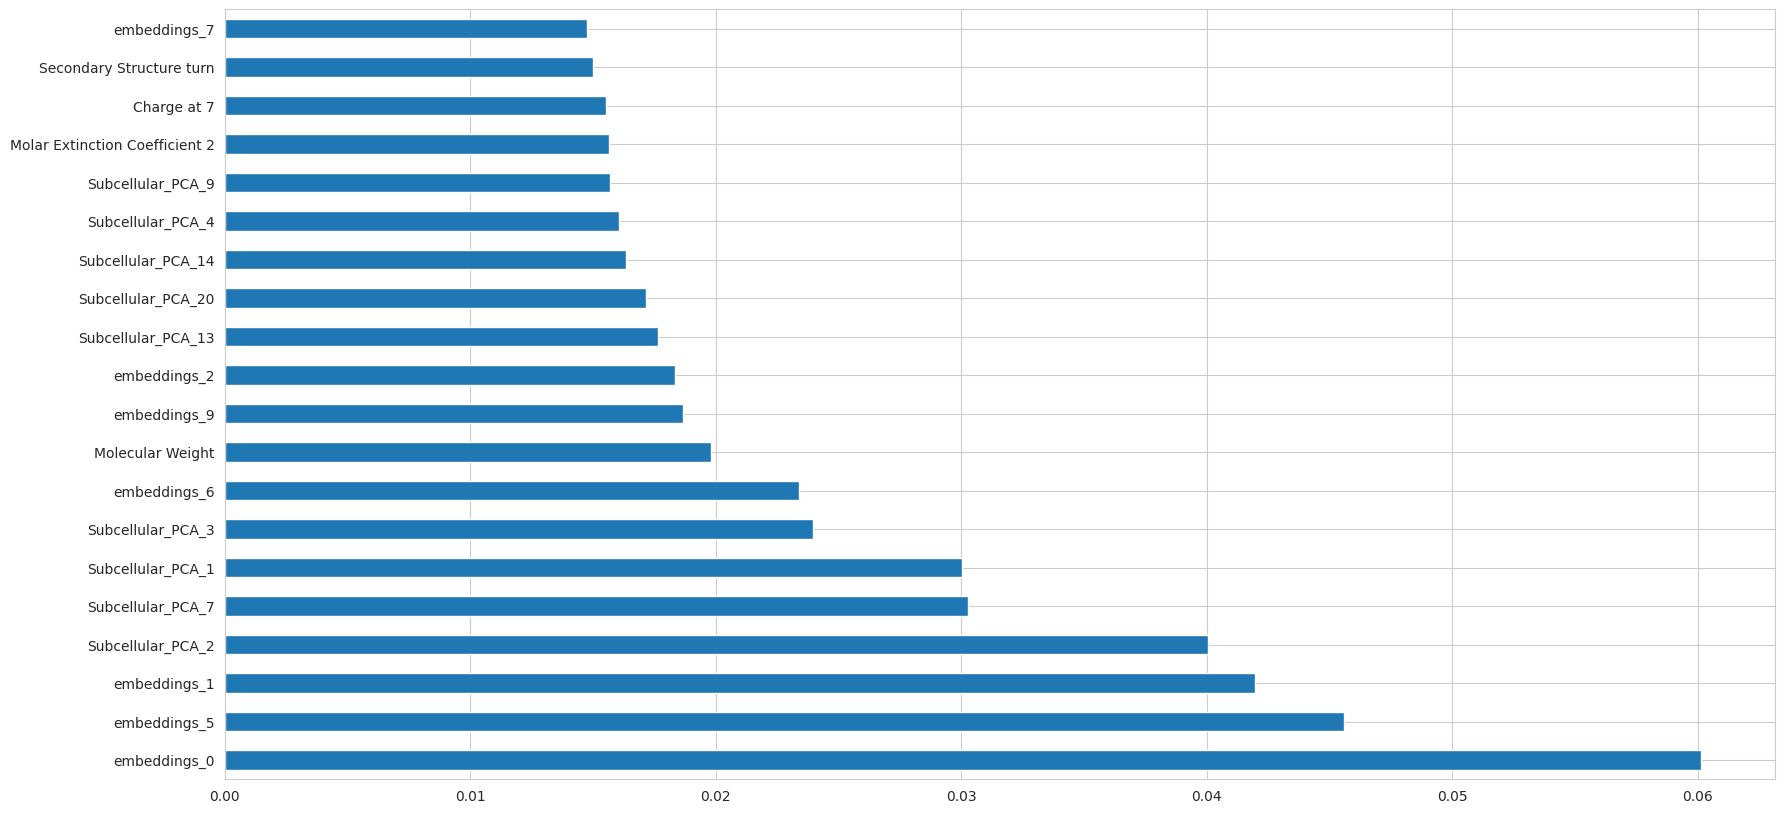

In [96]:
#lets see each feature importance using XGB Classifier
okk_1 = okk_1.drop(columns = ['is_approved'])
import xgboost

x_sample = okk_1.drop(columns = ['is_druggable'])
y_sample = okk_1['is_druggable']

model = xgboost.XGBClassifier()
model.fit(x_sample,y_sample)

feat_imp = pd.Series(model.feature_importances_, index=x_sample.columns)
print(feat_imp.sort_values())
feat_imp.nlargest(20).plot(kind='barh',figsize=(20,10))

plt.show()

In [97]:
#model building
X_train,X_test,y_train,y_test = train_test_split(x_sample,y_sample, test_size = 0.2, random_state = 123)
sc = StandardScaler()
oversample = SMOTE()
X_train,y_train = oversample.fit_resample(X_train,y_train)

X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

#using xgboost boosting algorithms
model_1 = xgboost.XGBClassifier()
model_1.fit(X_train,y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [98]:
def test_results(y_pred, y_test):
  results = {}
  results['Accuracy'] = accuracy_score(y_test,y_pred)
  results['Precision'] = precision_score(y_test,y_pred,average = 'weighted')
  results['Recall'] = recall_score(y_test,y_pred,average = 'weighted')
  results['F1_Score'] = f1_score(y_test,y_pred,average = 'weighted')

  cm = confusion_matrix(y_test,y_pred)
  return results,cm

In [99]:
y_pred = model_1.predict(X_test)
metrics_1,cm_1 = test_results(y_pred, y_test)

In [100]:
metrics_1

{'Accuracy': 0.8443846342060191,
 'Precision': 0.842551221374786,
 'Recall': 0.8443846342060191,
 'F1_Score': 0.8434419687386673}

In [101]:
#using logistic regression algorithm
model_2 = LogisticRegression()
model_2.fit(X_train,y_train)

LogisticRegression()

In [102]:
y_pred_2 = model_2.predict(X_test)
metrics_2, cm_2 = test_results(y_pred_2, y_test)

In [104]:
#using SVM algorithm using various kernels
model_3 = svm.SVC(kernel = 'linear',probability = True)
model_4 = svm.SVC(kernel = 'poly',probability = True)
model_5 = svm.SVC(kernel = 'rbf',probability = True)

model_3.fit(X_train,y_train)
model_4.fit(X_train,y_train)
model_5.fit(X_train,y_train)

SVC(probability=True)

In [105]:
y_pred_3 = model_3.predict(X_test)
metrics_3, cm_3 = test_results(y_pred_3, y_test)

y_pred_4 = model_4.predict(X_test)
metrics_4, cm_4 = test_results(y_pred_4, y_test)

y_pred_5 = model_3.predict(X_test)
metrics_5, cm_5 = test_results(y_pred_5, y_test)

In [106]:
#using RandomForest with estimator = 1500 which is no of trees employed
model_6 = RandomForestClassifier(n_estimators = 1500, criterion = 'entropy', random_state = 42)
model_6.fit(X_train,y_train)

RandomForestClassifier(criterion='entropy', n_estimators=1500, random_state=42)

In [107]:
y_pred_6 = model_6.predict(X_test)
metrics_6,cm_6 = test_results(y_pred_6,y_test)

In [108]:
#using ANN for classification

import tensorflow as tf
from tensorflow.keras import layers

model_7 = tf.keras.Sequential([
    layers.Dense(64, activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.3),
    layers.BatchNormalization(),
    layers.Dense(1, activation='sigmoid')
])

# Compile model
model_7.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [109]:
history = model_7.fit(X_train, y_train, validation_data = (X_test,y_test), epochs = 50)

Epoch 1/50
855/855 [==============================] - 11s 6ms/step - loss: 0.4948 - accuracy: 0.7649 - val_loss: 0.4444 - val_accuracy: 0.7788
Epoch 2/50
855/855 [==============================] - 6s 6ms/step - loss: 0.3976 - accuracy: 0.8242 - val_loss: 0.5049 - val_accuracy: 0.7578
Epoch 3/50
855/855 [==============================] - 4s 5ms/step - loss: 0.3506 - accuracy: 0.8489 - val_loss: 0.4536 - val_accuracy: 0.7932
Epoch 4/50
855/855 [==============================] - 4s 5ms/step - loss: 0.3120 - accuracy: 0.8703 - val_loss: 0.4956 - val_accuracy: 0.7773
Epoch 5/50
855/855 [==============================] - 6s 7ms/step - loss: 0.2821 - accuracy: 0.8837 - val_loss: 0.4896 - val_accuracy: 0.7974
Epoch 6/50
855/855 [==============================] - 4s 5ms/step - loss: 0.2569 - accuracy: 0.8950 - val_loss: 0.4616 - val_accuracy: 0.8255
Epoch 7/50
855/855 [==============================] - 4s 5ms/step - loss: 0.2323 - accuracy: 0.9090 - val_loss: 0.5134 - val_accuracy: 0.8087
Epoch

In [110]:
y_pred_7 = model_7.predict(X_test)
y_pred_7 = (y_pred_7 >= 0.5).astype(int)
metrics_7,cm_7 = test_results(y_pred_7,y_test)

128/128 [==============================] - 0s 2ms/step


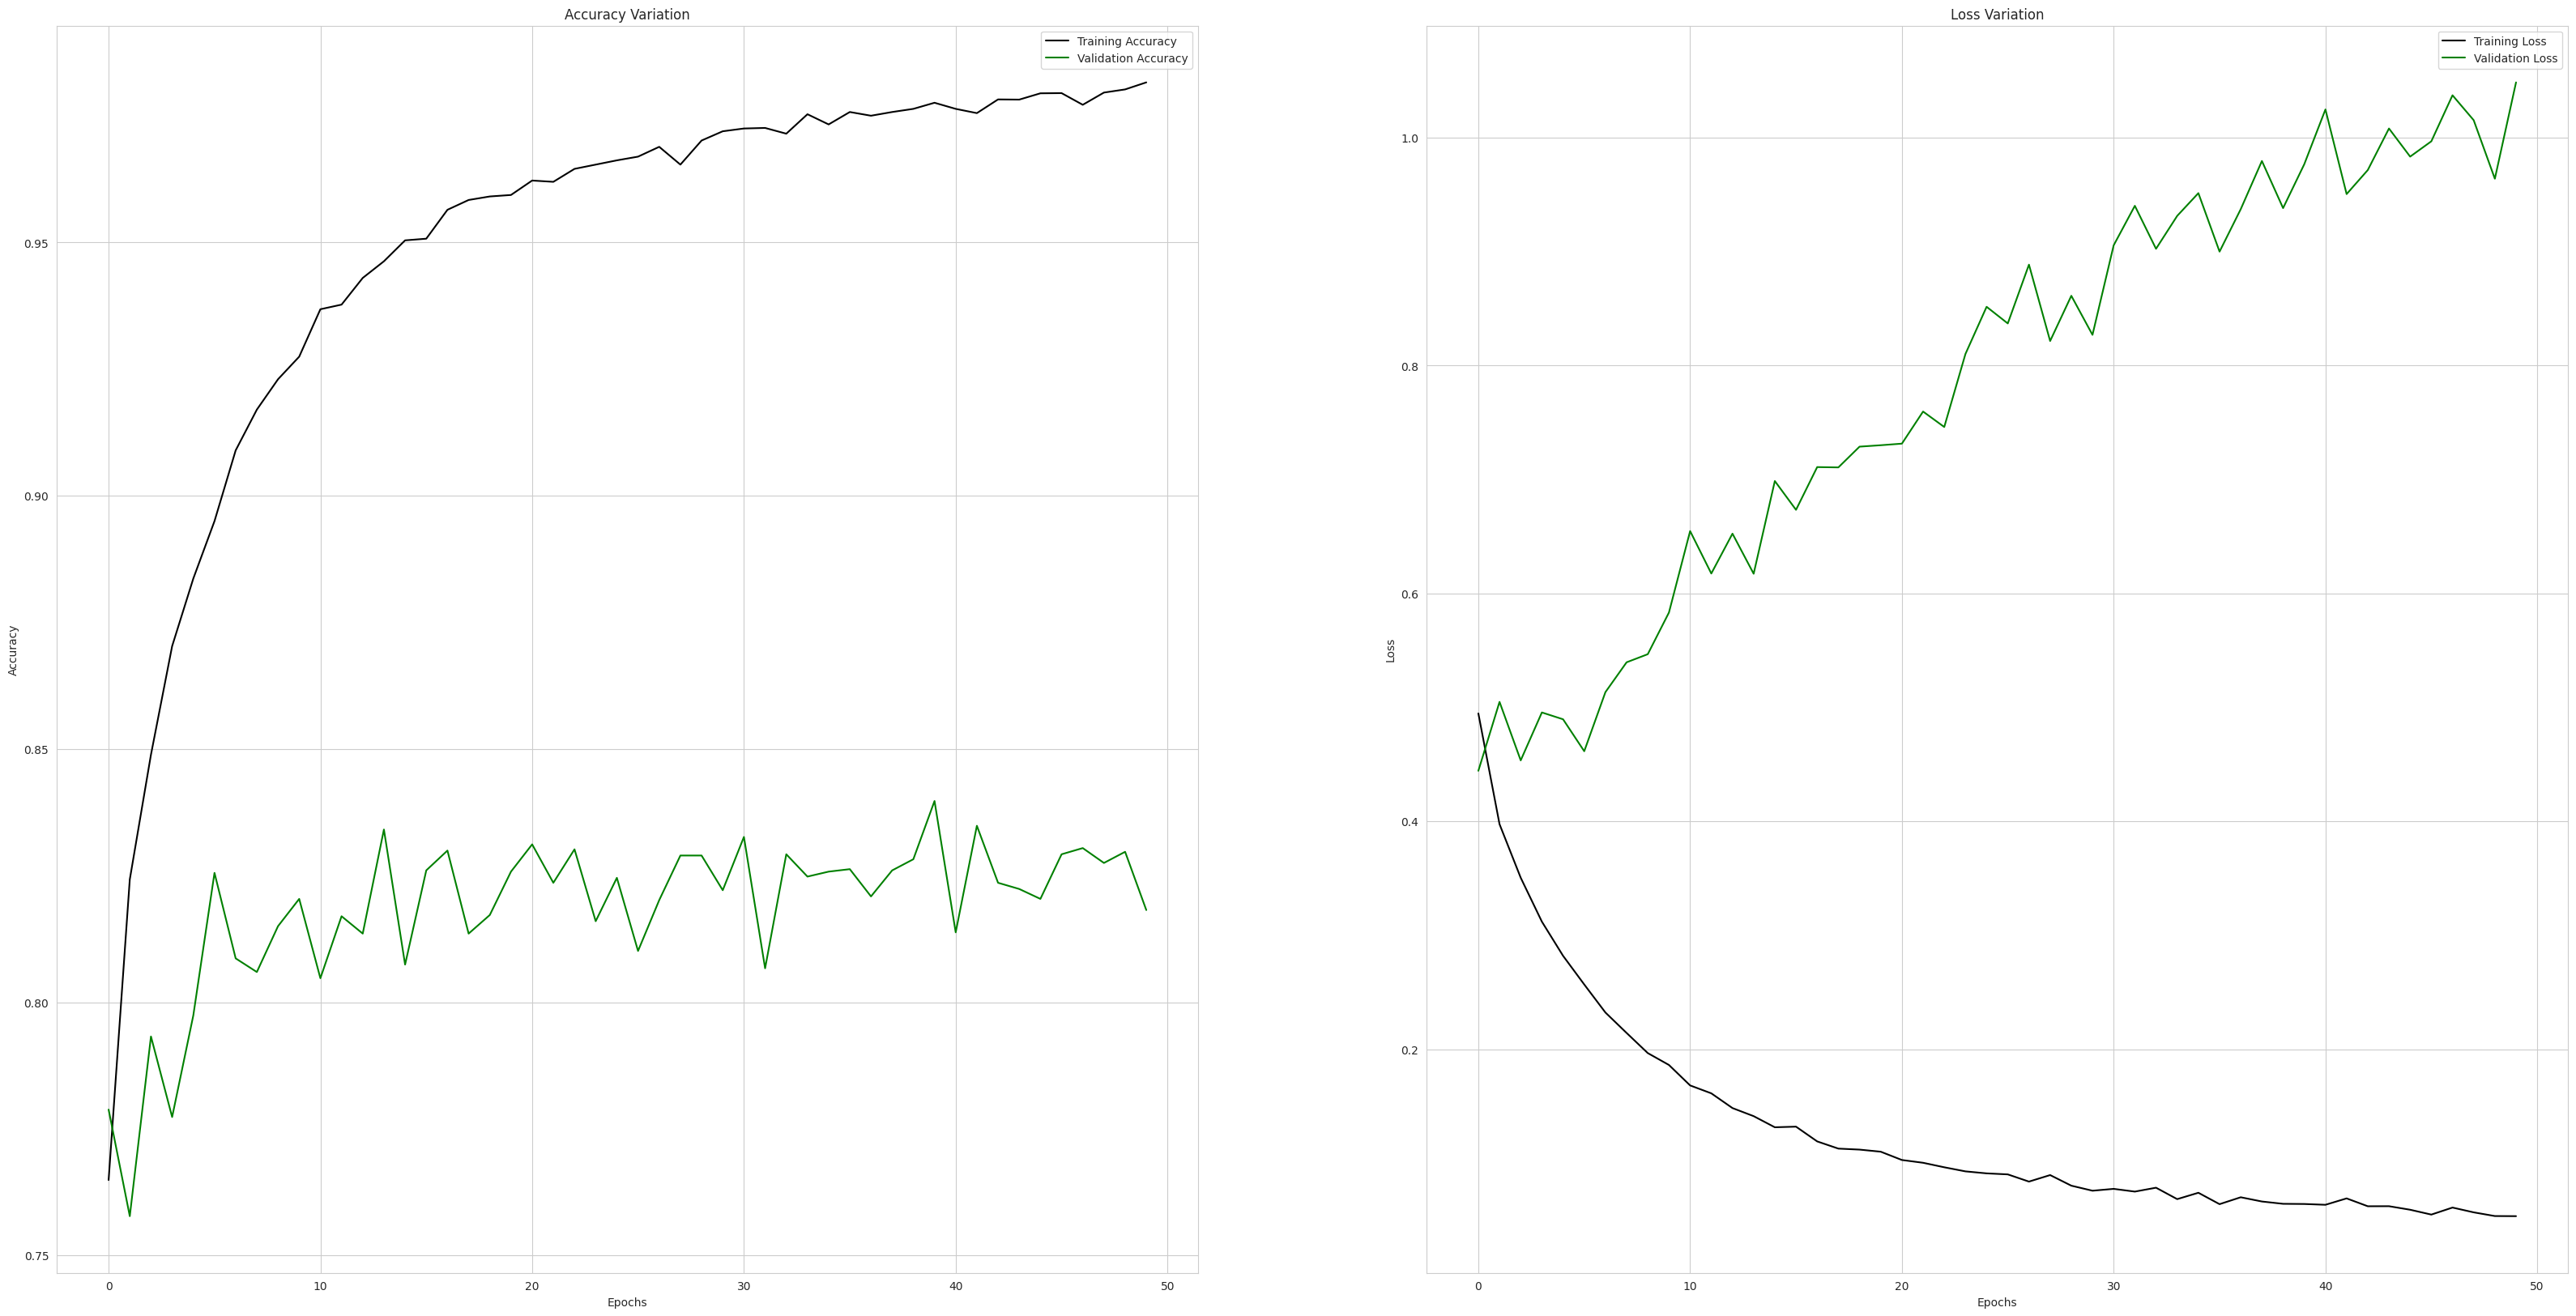

In [111]:
fig,ax = plt.subplots(figsize = (40,20), ncols = 2)
ax[0].plot(history.history['accuracy'],color = 'black', label = 'Training Accuracy')
ax[0].plot(history.history['val_accuracy'],color = 'green', label = 'Validation Accuracy')
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_title('Accuracy Variation')
ax[0].legend()

ax[1].plot(history.history['loss'],color = 'black', label = 'Training Loss')
ax[1].plot(history.history['val_loss'],color = 'green', label = 'Validation Loss')
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_title('Loss Variation')
ax[1].legend()
plt.show()

In [112]:
model_list = {
    "XGBoost" : pd.Series(metrics_1),
    "Logistic_Regression" : pd.Series(metrics_2),
    "SVM_Linear" : pd.Series(metrics_3),
    "SVM_Polynomial" : pd.Series(metrics_4),
    "SVM_RBF" : pd.Series(metrics_5),
    "Random_Forest" : pd.Series(metrics_6),
    "ANN" : pd.Series(metrics_7)
}

pd.DataFrame(model_list).T


Accuracy  Precision    Recall  F1_Score
XGBoost              0.844385   0.842551  0.844385  0.843442
Logistic_Regression  0.707365   0.823109  0.707365  0.742191
SVM_Linear           0.703695   0.828786  0.703695  0.739790
SVM_Polynomial       0.753609   0.840284  0.753609  0.780338
SVM_RBF              0.703695   0.828786  0.703695  0.739790
Random_Forest        0.854906   0.846906  0.854906  0.850202
ANN                  0.818204   0.831251  0.818204  0.823954

<ipython-input-113-cb14ed04e3bd>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x = okk[1], y = okk[0], data = okk, palette='viridis')


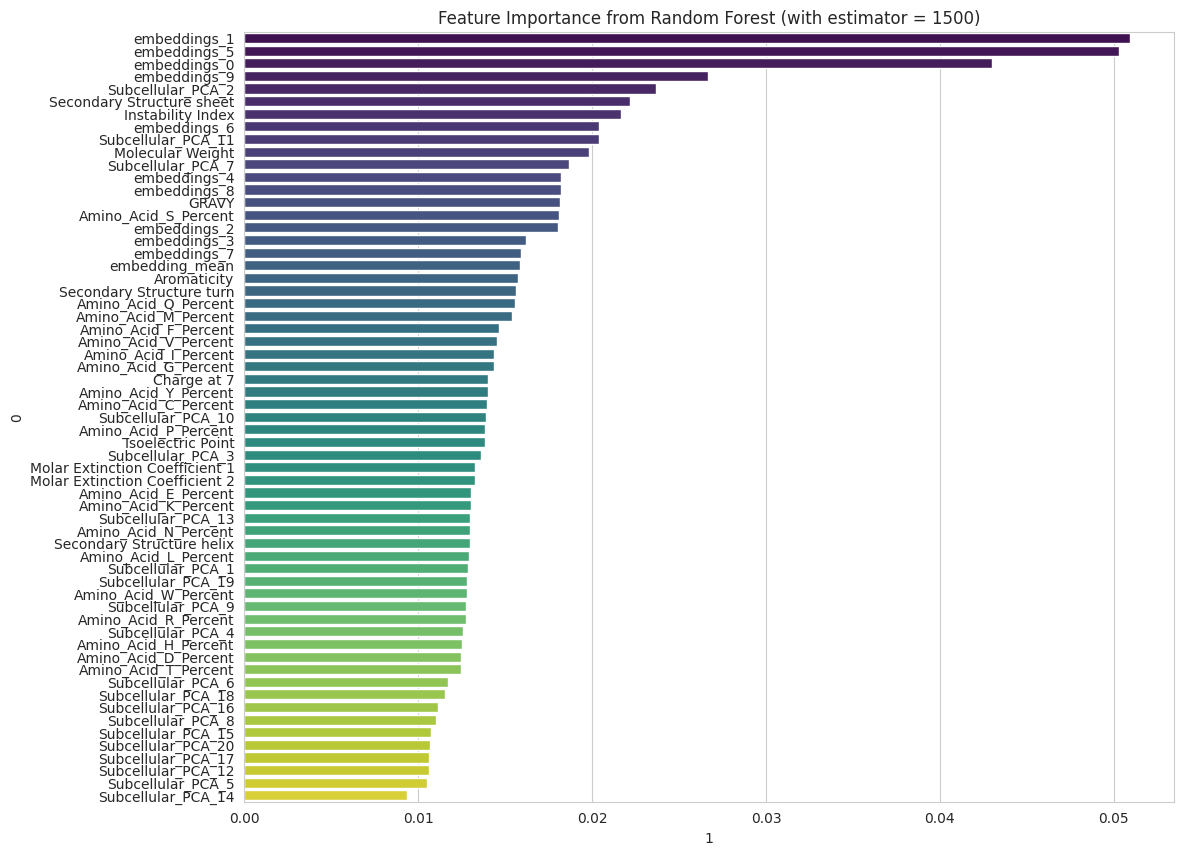

In [113]:
feature_importance = model_6.feature_importances_
okk = pd.DataFrame([x_sample.columns, feature_importance]).T
okk = okk.sort_values(by = 1,ascending = False)
plt.figure(figsize=(12, 10))
sns.barplot(x = okk[1], y = okk[0], data = okk, palette='viridis')
plt.title("Feature Importance from Random Forest (with estimator = 1500)")
plt.show()

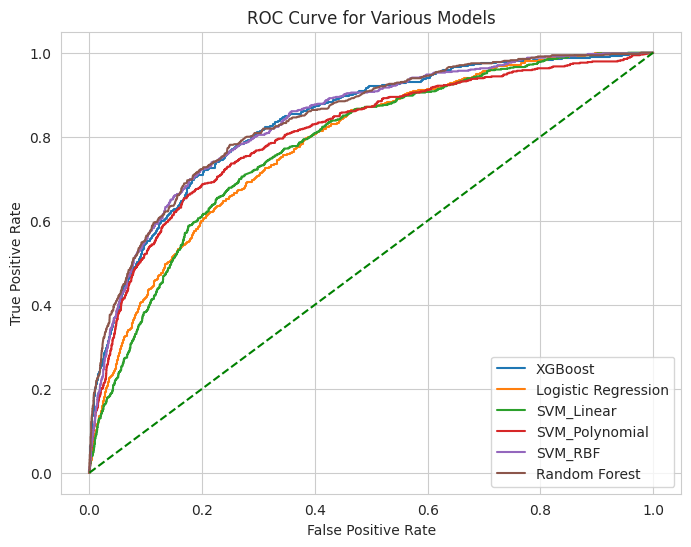

In [114]:
#roc-auc curve for various algorithm
fpr_1, tpr_1, _ = roc_curve(y_test, model_1.predict_proba(X_test)[:, 1])
fpr_2, tpr_2, _ = roc_curve(y_test, model_2.predict_proba(X_test)[:, 1])
fpr_3, tpr_3, _ = roc_curve(y_test, model_3.predict_proba(X_test)[:, 1])
fpr_4, tpr_4, _ = roc_curve(y_test, model_4.predict_proba(X_test)[:, 1])
fpr_5, tpr_5, _ = roc_curve(y_test, model_5.predict_proba(X_test)[:, 1])
fpr_6, tpr_6, _ = roc_curve(y_test, model_6.predict_proba(X_test)[:, 1])

# Plot ROC curves for each model
plt.figure(figsize=(8, 6))
plt.plot(fpr_1, tpr_1, label='XGBoost')
plt.plot(fpr_2, tpr_2, label='Logistic Regression')
plt.plot(fpr_3, tpr_3, label='SVM_Linear')
plt.plot(fpr_4, tpr_4, label='SVM_Polynomial')
plt.plot(fpr_5, tpr_5, label='SVM_RBF')
plt.plot(fpr_6, tpr_6, label='Random Forest')


# Plot the diagonal line (random classifier)
plt.plot([0, 1], [0, 1], color='green', linestyle='--')

# Set labels and title
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Various Models')
plt.legend()
plt.show()

In [ ]:
# import copy

# def evaluate_classifier(features, labels):
#     X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)
#     clf = RandomForestClassifier(n_estimators=100, random_state=42)
#     clf.fit(X_train, y_train)
#     y_pred = clf.predict(X_test)
#     return accuracy_score(y_test, y_pred)

# def evaluate_feature_set(feature_set, dataset):
#     features = dataset[feature_set]
#     labels = dataset['is_druggable']
#     return evaluate_classifier(features, labels)

# def evaluate_best_feature_subset(C, S, D):
#     return evaluate_feature_set(S, D)

# def update_feature_subset(S, best_feature):
#     S.append(best_feature)

# def iwssr(D, C, F):
#     best_feature_subset = []
#     best_feature_subset_score = 0

#     for i in range(len(F)):
#         best = None
#         if len(best_feature_subset) == 0:
#             S_sel = [F[i]]
#             feature_score = evaluate_feature_set(S_sel, D)
#             if feature_score > best_feature_subset_score:
#                 best = F[i]
#                 best_feature_subset_score = feature_score
#         else:
#             for j in range(len(best_feature_subset)):
#                 S_sel = copy.deepcopy(best_feature_subset)
#                 S_sel[j] = F[i]
#                 feature_score = evaluate_feature_set(S_sel, D)

#                 if feature_score > best_feature_subset_score:
#                     best = F[i]
#                     best_feature_subset_score = feature_score

#         if best is not None:
#             best_feature_subset.append(best)

#     return best_feature_subset

# # Example usage:
# # Assume dataset is a pandas DataFrame containing features and labels
# # D = dataset
# # C = RandomForestClassifier
# # F = list of features

# best_features = iwssr(okk_1, RandomForestClassifier(), list(okk_1.columns[:-1]))
# print("Best feature subset:", best_features)
